In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
import numpy as np
%matplotlib inline

/Users/xbno/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def clean_raw(bc_full_df):
    import numpy as np
    import pandas as pd
    import pandas as pd
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    %matplotlib inline

    #alsways drop these cols
    bc_full_df = bc_full_df.drop('Worksheet Filter',axis=1)
    bc_full_df = bc_full_df.drop('Measure Display',axis=1)
    bc_full_df = bc_full_df.drop('Number of Records',axis=1)
    bc_full_df = bc_full_df.drop('Unnamed: 0',axis=1)
    bc_full_df = bc_full_df.drop('State',axis=1)
    bc_full_df = bc_full_df.drop('Table Id',axis=1)
    bc_full_df = bc_full_df.drop('Period Duration',axis=1)
    bc_full_df = bc_full_df.drop('Period Begin',axis=1)
    
    #drop when doing neighborhoods
#     bc_full_df = bc_full_df.drop('months_of_supply',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_yoy',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_mom',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Yoy',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Mom',axis=1)

    #lgo transforms of two variables so I can potentially use the additive decomposition
    bc_full_df['Inventory'] = np.log(bc_full_df['Inventory'])
    bc_full_df['months_of_supply'] = np.log(bc_full_df['months_of_supply'])


    #rename months_of_supply
    bc_full_df.rename(columns = {'months_of_supply': 'Months of Supply',
                                'months_of_supply_mom': 'Months of Supply Mom',
                                'months_of_supply_yoy': 'Months of Supply Yoy'}, inplace=True)

    #drop 2nd date col
#     dates = ['Period End'] #dropped Period End
#     for col in dates:
#         bc_full_df[col] = pd.to_datetime(bc_full_df[col])
    
    #format percent cols
    percents = ['Median Sale Price Mom',
    'Median Sale Price Yoy',
    'New Listings Mom',
    'New Listings Yoy',
    'Homes Sold Mom',
    'Homes Sold Yoy',
    'Inventory Mom',
    'Inventory Yoy',
    'Avg Sale To List Mom',
    'Avg Sale To List Yoy']
    for col in percents:
        bc_full_df[col] = bc_full_df[col].str.strip('%')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
        
    #format money cols
    prices = ['Median Sale Price']
    for col in prices:
        bc_full_df[col] = bc_full_df[col].str.strip('$').str.strip('K').str.replace(',','')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
    
    #change scale
    bc_full_df['Median List Price'] = bc_full_df['Median List Price'] / 1000.0
    
    #set index
    bc_full_df['Period End'] = pd.to_datetime(bc_full_df['Period End'])
    bc_full_df = bc_full_df.sort_values('Period End')
    bc_full_df = bc_full_df.set_index('Period End')
    
    return bc_full_df

In [3]:
def test_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(6, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [4]:
#test_stationarity(differenced(bos['Median Dom']).values.ravel())

In [5]:
def decomp(series,trend=False,seas=False,resid=True,model='add'):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    df = pd.DataFrame()
    col_decomp = sm.tsa.seasonal_decompose(series, model=model,two_sided=False)
    #df[col] = col_decomp.observed
    if trend:
        df[series.name+' Trend'] = col_decomp.trend
    if seas:
        df[series.name+' Seasonal'] = col_decomp.seasonal
    if resid:
        df[series.name+' Residual'] = col_decomp.resid
    return df#, target_trend, target_seasonal

In [6]:
def diff(series,lag1=True,lag12=True):
    df = pd.DataFrame()
    lag = (series-series.shift(1)).dropna(axis=0)
    if lag1 and lag12:
        df[series.name+' Lag'] = (lag - lag.shift(12)).dropna()
    elif lag1:
        df[series.name+' Lag1'] = lag
    elif lag12:
        df[series.name+' Lag12'] = (series - series.shift(12)).dropna()
    return df

In [7]:
def read_data(df,reg_type='metro'):
    #format data
    df = clean_raw(df)
    
    #create wide version of file
    #reg_type = 'place'
    rn_master_df = pd.DataFrame()
    for reg in [reg for reg in df[(df['Region Type'] == reg_type) | (df['Region Type'] == 'national')]['Region'].unique()]:
        reg_df = df[df['Region'] == reg]
        #print('---'+reg)
        rn_reg_df = pd.DataFrame()
        for prop in [prop for prop in reg_df['Property Type'].unique()]:
            prop_df = reg_df[reg_df['Property Type'] == prop]
            rn_dict = {}
            #print('--'+prop)
            for col in [col for col in prop_df.columns if prop_df[col].dtype != 'object']:
                rn_dict[col] = reg+' '+prop+' '+col
                #print(reg+' '+prop+' '+col)
            prop_df = prop_df.rename(columns=rn_dict)
            prop_df = prop_df.drop([col for col in prop_df.columns if prop_df[col].dtype == 'object'],axis=1)
            rn_reg_df = pd.concat([rn_reg_df,prop_df],axis=1)
        rn_master_df = pd.concat([rn_master_df,rn_reg_df],axis=1)
        
    #drop 'object' columns from renamed master
    #rn_master_df = rn_master_df.drop([col for col in rn_master_df.columns if rn_master_df[col].dtype == 'object'],axis=1)
    
    return rn_master_df

In [8]:
#df_nat = read_data(raw)

In [9]:
def subset(df,term):
    import re
    return df[[col for col in df.columns if re.findall(term,col)]]

In [10]:
def plot(df,term,fig=(15,4)):
    #term = 'Median Sale Price'
    import re
    df[[col for col in df.columns if re.findall(term+'$',col)]].plot(figsize=fig)

In [11]:
#plot(df,'Single Family Residential Median Sale Price',(15,8))

In [12]:
#plot(df_combo,'Median Sale Price.+Residual')

# Comparison between the residuals of decomposition vs differencing
They seem to tell two different stories, maybe I should keep both?

In [13]:
# difference(bos['Median Dom']).plot()
# decomp(bos['Median Dom']).plot()

# test_stationarity(difference(df['Median Dom']).values.ravel())
# test_stationarity(decomp(df['Median Dom']).dropna().values.ravel())

In [14]:
def difference(df,cols,drop_orig=True):
    for col in cols:
        df = pd.concat([df,diff(df[col])],axis=1)
        if drop_orig:
            df.drop(col,axis=1,inplace=True)
    return df

In [15]:
def decompose(df,cols,drop_orig=True,resid=True,trend=False,seas=False):
    for col in cols:
        df = pd.concat([df,decomp(df[col],resid=resid,trend=trend,seas=seas)],axis=1)
        if drop_orig:
            df.drop(col,axis=1,inplace=True)
    #target_trend = decomp(df[col],resid=False,trend=True)
    #target_seas = decomp(df[col],resid=False,seas=True)
    return df#, target_trend, target_seas

In [16]:
def decompose_target(df,cols,drop_orig=True,resid=False,trend=True,seas=True):
    target_trend = decomp(df[col],resid=resid,trend=trend)
    target_seas = decomp(df[col],resid=resid,seas=seas)
    return pd.Series(target_trend), pd.Series(target_seas)

In [17]:
def scatter(df_combo,term):
    #term = 'Lag'
    import re
    import seaborn as sns
    fig, axes = plt.subplots(nrows=6, ncols=6)

    thing = [col for col in df_combo.columns if re.findall(term+'\\b',col)]

    for i, ax in enumerate(axes.reshape(-1)):
        df_combo.plot(x=[col for col in df_combo.columns if re.findall('Median Sale Price '+term+'\\b',col)][0]
                ,y=thing[i],kind='scatter',ax=ax,figsize=(18,18))

In [18]:
def create_supervised(df,term):    
    bos = df.copy()
    target = [col for col in bos.columns if re.findall(term+'$',col)][0]
    #print(target)
    #target = 'Median Sale Price'
    for col in [col for col in bos.columns if col != target]:
        if term not in col:
            for t in range(0,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
        else:
            for t in range(1,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
    
    for f in range(1,2):
        bos[target+' T+'+str(f)] = bos[target].shift(-f)

    bos.drop(target,axis=1,inplace=True)    
    bos = bos.dropna(axis=0)
    return bos

In [19]:
# import pandas as pd
# import re
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# import seaborn as sns

# df = pd.read_csv('./bost_camb_full.csv')
# df = read_data(df)
# df = subset(df,'Boston, MA')
# #df = subset(df,'Townhouse')
# df = df.dropna(axis=1)
# df_decomp = decompose(df,df.columns)
# df_diff = difference(df,df.columns)
# df_combo = pd.concat([df_decomp,df_diff],axis=1)
# df_combo = df_combo.dropna(axis=0)

In [20]:
#plot(df_combo,'.+Median Sale Price Lag')
#plot(df_combo,'Median Sale Price Residual')

# case shiller

In [22]:
#case_shiller_df

# top 50 metros

In [23]:
# multi_top50 = pd.read_csv('./multi_top50.csv',sep='\t',encoding='utf-16')
# townhouse_top50 = pd.read_csv('./townhouse_top50.csv',sep='\t',encoding='utf-16')
# single_top50 = pd.read_csv('./single_top50.csv',sep='\t',encoding='utf-16')
# condo_top50 = pd.read_csv('./condo_top50.csv',sep='\t',encoding='utf-16')
# all_top50 = pd.read_csv('./all_top50.csv',sep='\t',encoding='utf-16')

In [24]:
# top50 = pd.concat([multi_top50,townhouse_top50,single_top50,condo_top50,all_top50])

In [25]:
# top50.to_csv('raw_top50.csv')

In [26]:
# raw = pd.read_csv('./raw_top50.csv')
# df = read_data(raw)

In [27]:
# df.to_csv('clean_top50.csv')

In [28]:
# df = pd.read_csv('./clean_top50.csv')

# works

# make functions

In [21]:
def TestTrainTimes(time_list):
    end_first_3_years = time_list[0]
    start_middle_3_years = time_list[1]
    end_middle_3_years = time_list[2]
    start_last_3_years = time_list[3]
    start_last_6_years = time_list[4]
    return end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years

In [22]:
def Target(df_orig,target,city_df,time_list):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #setup target variables
    y_last_6 = df_orig[start_last_6_years:][target]
    y_mid_6 = y_last_6[start_middle_3_years:end_middle_3_years]
    y_last_3 = df_orig[start_last_3_years:][target]
    #save target
    city_df = pd.concat([city_df,y_last_3],axis=1)
    return city_df

In [23]:
def ARMA(df_orig,target,city_df,resid_df,time_list,param):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #arma
    #param = (16,0,1)
    mod = sm.tsa.statespace.SARIMAX(df_orig[target],order=param,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #setup target variables
    y_last_6 = df_orig[start_last_6_years:][target]
    y_mid_6 = y_last_6[start_middle_3_years:end_middle_3_years]
    y_last_3 = df_orig[start_last_3_years:][target]
    #arma prediction
    best_arma_pred_last_6 = results.predict(start_last_6_years,dynamic=False)
    best_arma_pred_mid_3 = best_arma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_arma_pred_last_3 = results.predict(start_last_3_years,dynamic=False)
    best_arma_pred_last_3.name = target+' Best ARMA '+str(param)
    #arma residual from target
    best_arma_resid_last_6 = (y_last_6 - best_arma_pred_last_6)
    best_arma_resid_last_6.name = target+' Best ARMA Resid'
    #save pred
    if y_last_3.name in city_df.columns:
        city_df = pd.concat([city_df,best_arma_pred_last_3],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_3,best_arma_pred_last_3],axis=1)        
    #save pred when gridsearching
    #city_df = pd.concat([city_df,y_last_3,best_arma_pred_last_3],axis=1)
    #save resid
    resid_df = pd.concat([resid_df,best_arma_resid_last_6],axis=1)
    return city_df, resid_df, best_arma_pred_last_3

In [24]:
def ARMA2(df_orig,target,city_df,resid_df,time_list,param):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #arma
    #param = (16,0,1)
    mod = sm.tsa.statespace.SARIMAX(df_orig[target],order=param,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #setup target variables
    y_last_6 = df_orig[start_last_6_years:][target]
    y_mid_6 = y_last_6[start_middle_3_years:end_middle_3_years]
    y_last_3 = df_orig[start_last_3_years:][target]
    #arma prediction
    best_arma_pred_last_6 = results.predict(start_last_6_years,dynamic=False)
    best_arma_pred_last_6.name = target+' Best ARMA '+str(param)
    best_arma_pred_mid_3 = best_arma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_arma_pred_last_3 = results.predict(start_last_3_years,dynamic=False)
    best_arma_pred_last_3.name = target+' Best ARMA '+str(param)
    #arma residual from target
    best_arma_resid_last_6 = (y_last_6 - best_arma_pred_last_6)
    best_arma_resid_last_6.name = target+' Best ARMA Resid'
    #save pred
    if y_last_6.name in city_df.columns:
        city_df = pd.concat([city_df,best_arma_pred_last_6],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_6,best_arma_pred_last_6],axis=1)        
    #save pred when gridsearching
    #city_df = pd.concat([city_df,y_last_3,best_arma_pred_last_3],axis=1)
    #save resid
    resid_df = pd.concat([resid_df,best_arma_resid_last_6],axis=1)
    return city_df, resid_df, best_arma_pred_last_3

In [25]:
def SARMA(df_orig,target,city_df,time_list,param,param_seasonal):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #sarma
#     param = (12,1,1)
#     param_seasonal = (1,1,1,12)
    mod = sm.tsa.statespace.SARIMAX(df_orig[target],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #sarma prediction
    best_sarma_pred_last_6 = results.predict(start_last_6_years,dynamic=False)
    best_sarma_pred_mid_3 = best_sarma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_sarma_pred_last_3 = results.predict(start_last_3_years,dynamic=False)
    best_sarma_pred_last_3.name = target+' Best SARMA '+str(param)
    #target
    y_last_3 = df_orig[start_last_3_years:][target]
    #save pred
    if y_last_3.name in city_df.columns:
        city_df = pd.concat([city_df,best_sarma_pred_last_3],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_3,best_sarma_pred_last_3],axis=1)  
    #save pred
#     city_df = pd.concat([city_df,best_sarma_pred_last_3],axis=1)
    return city_df

In [26]:
def SARMA2(df_orig,target,city_df,time_list,param,param_seasonal):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #sarma
#     param = (12,1,1)
#     param_seasonal = (1,1,1,12)
    mod = sm.tsa.statespace.SARIMAX(df_orig[target],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #sarma prediction
    best_sarma_pred_last_6 = results.predict(start_last_6_years,dynamic=False)
    best_sarma_pred_last_6.name = target+' Best SARMA '+str(param)
    best_sarma_pred_mid_3 = best_sarma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_sarma_pred_last_3 = results.predict(start_last_3_years,dynamic=False)
    best_sarma_pred_last_3.name = target+' Best SARMA '+str(param)
    #target
    y_last_6 = df_orig[start_middle_3_years:][target]
    #save pred
    if y_last_6.name in city_df.columns:
        city_df = pd.concat([city_df,best_sarma_pred_last_6],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_6,best_sarma_pred_last_6],axis=1)  
    #save pred
#     city_df = pd.concat([city_df,best_sarma_pred_last_3],axis=1)
    return city_df

In [27]:
def PRED_ARMA_RESID(df_orig,target,best_arma_pred_last_3,best_arma_resid_last_6,city_df,time_list):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #predict arma resid
    term = target+' Best ARMA Resid'
    df = df_orig.copy()
    df = pd.concat([df,best_arma_resid_last_6],axis=1)
    city_dict = {}
    #initilize
    all_top_feat_df = pd.DataFrame()
    #build df can handle multiple property types if given
    for target_col in [col for col in df.columns if re.findall(term+'$',col)]:
        print(target_col)
        #top_feat_df = pd.DataFrame()
        df_super = create_supervised(df,target_col)
        top_feat = list(zip(list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10).index),
                            list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10))))
        #collect top 10 corr per target
        top_feat_df = pd.DataFrame(top_feat)
        top_feat_df.columns = [target_col,target_col+' Corr']
        top_feat_df = top_feat_df.set_index(target_col)
        all_top_feat_df = pd.concat([all_top_feat_df,top_feat_df],axis=1)
        #save each df_super in this dictionary, drop nan rows from lagging vars
        city_dict[target_col] = df_super
    #loop through dfs within the city_dict and 
    df = city_dict[term]

    #target var, X and y
    target_t1 = term+' T+1'
    X = df.drop([target_t1],axis=1)
    y = df[target_t1]
    #timewise
    X_train = X[start_middle_3_years:end_middle_3_years]
    y_train = y[start_middle_3_years:end_middle_3_years]
    X_test = X[end_middle_3_years:]
    y_test = y[end_middle_3_years:]
    #model
    #reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
    #reg = LinearSVR(C=.1, epsilon=5)
    reg = RandomForestRegressor(n_estimators=200)
    #reg = ElasticNet(l1_ratio=.3) 
    #model fit
    reg.fit(X_train,y_train)
    best_arma_resid_pred_last_3 = reg.predict(X_test)
    best_arma_resid_pred_last_3 = pd.Series(best_arma_resid_pred_last_3)
    best_arma_resid_pred_last_3.index = y_test.index
    best_arma_resid_pred_last_3.name = target+' Best ARMA Resid Pred'
    best_arma_add_pred_last_3 = (best_arma_pred_last_3-best_arma_resid_pred_last_3)
    best_arma_add_pred_last_3.name = target+' Best ARMA Add'
    score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
    print(np.sqrt(-score).mean())
    #save pred
    city_df = pd.concat([city_df,best_arma_add_pred_last_3],axis=1)
    return city_df

In [28]:
def DECOMP(df_orig,target,city_df,time_list):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    term = target
    df = df_orig.copy()

    #either decompose or diff, then clean up 
    df = decompose(df,df.columns)
    term = target+' Residual'
    df = df.dropna(axis=0)

    #target variable - Remember its Lag or Residual if using diff/decomposition
    city_dict = {}

    #initilize
    all_top_feat_df = pd.DataFrame()

    #run loop for each property type
    for target_col in [col for col in df.columns if re.findall(term+'$',col)]:
        print(target_col)
        #top_feat_df = pd.DataFrame()
        df_super = create_supervised(df,target_col)
        top_feat = list(zip(list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10).index),
                            list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10))))

        #collect top 10 corr per target
        top_feat_df = pd.DataFrame(top_feat)
        top_feat_df.columns = [target_col,target_col+' Corr']
        top_feat_df = top_feat_df.set_index(target_col)
        all_top_feat_df = pd.concat([all_top_feat_df,top_feat_df],axis=1)

        #save each df_super in this dictionary, drop nan rows from lagging vars
        city_dict[target_col] = df_super

    df = city_dict[term]

    #remove residual mean, add back in later
    mean_resid_dict = {}
    for col in [col for col in df.columns if re.findall(r'Residual\b',col)]:
        mean_resid_dict[col] = df[col].mean()
        df[col] = df[col] - df[col].mean()

    target_t1 = term+' T+1'
    X = df.drop([target_t1],axis=1)
    y = df[target_t1]

    #timewise
    X_train = X[start_middle_3_years:end_middle_3_years]
    y_train = y[start_middle_3_years:end_middle_3_years]
    X_test = X[end_middle_3_years:]
    y_test = y[end_middle_3_years:]

    #model
    #reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
    #reg = LinearSVR(C=.1, epsilon=5)
    reg = RandomForestRegressor(n_estimators=200)
    #reg = ElasticNet(l1_ratio=.3)

    #model fit
    reg.fit(X_train,y_train)
    y_pred_add = reg.predict(X_test)
    y_pred_add = pd.Series(y_pred_add)
    y_pred_add.index = y_test.index
    score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
    print(np.sqrt(-score).mean())

    #trend, trend+seasonality, trend+seasonality+add predictions
    col_decomp = sm.tsa.seasonal_decompose(df_orig[target],two_sided=False)
    trend_seas_add_pred = (col_decomp.trend+col_decomp.seasonal+mean_resid_dict[target_t1]+y_pred_add.shift())
    trend_seas_pred = (col_decomp.trend+col_decomp.seasonal+mean_resid_dict[target_t1])
    trend_pred = (col_decomp.trend+mean_resid_dict[target_t1])

    #subset to only last 3 yrs
    trend_seas_add_pred_last_3 = trend_seas_add_pred[start_last_3_years:]
    trend_seas_add_pred_last_3.name = target+' Trend Seasonality Additional'
    trend_seas_pred_last_3 = trend_seas_pred[start_last_3_years:]
    trend_seas_pred_last_3.name = target+' Trend Seasonality'
    trend_pred_last_3 = trend_pred[start_last_3_years:]
    trend_pred_last_3.name = target+' Baseline Trend'

    #save pred
    city_df = pd.concat([city_df,trend_pred_last_3,trend_seas_pred_last_3,trend_seas_add_pred_last_3],axis=1)
    return city_df

In [29]:
def DECOMP2(df_orig,target,city_df,time_list):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    
    term = target
    df = df_orig.copy()

    #either decompose or diff, then clean up 
#     df = decompose(df,df.columns)
#     term = target+' Residual'
#     df = df.dropna(axis=0)

    #remove residual mean, add back in later
#     mean_resid_dict = {}
#     for col in [col for col in df.columns if re.findall(r'Residual\b',col)]:
#         mean_resid_dict[col] = df[col].mean()
#         df[col] = df[col] - df[col].mean()
    
    #trend, trend+seasonality, trend+seasonality+add predictions
    col_decomp = sm.tsa.seasonal_decompose(df_orig[target],two_sided=False)
    trend_seas_pred = (col_decomp.trend+col_decomp.seasonal) # +mean_resid_dict[target_t1]
    trend_pred = (col_decomp.trend) # +mean_resid_dict[target_t1]
    
    #subset to only last 3 yrs
    trend_seas_pred_last_6 = trend_seas_pred[start_middle_3_years:]
    trend_seas_pred_last_6.name = target+' Trend Seasonality'
    trend_pred_last_6 = trend_pred[start_middle_3_years:]
    trend_pred_last_6.name = target+' Baseline Trend'

    #save pred
    city_df = pd.concat([city_df,trend_pred_last_6,trend_seas_pred_last_6],axis=1)
    return city_df

In [30]:
def DIFF(df_orig,target,city_df,time_list):
    df = df_orig.copy()

    #either decompose or diff, then clean up 
    df = difference(df,df.columns)
    term = target+' Diff'
    df = df.dropna(axis=0)

    #target variable - Remember its Lag or Residual if using diff/decomposition
    city_dict = {}

    #initilize
    all_top_feat_df = pd.DataFrame()

    #run loop for each property type
    for target_col in [col for col in df.columns if re.findall(term+'$',col)]:
        print(target_col)
        #top_feat_df = pd.DataFrame()
        df_super = create_supervised(df,target_col)
        top_feat = list(zip(list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10).index),
                            list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10))))

        #collect top 10 corr per target
        top_feat_df = pd.DataFrame(top_feat)
        top_feat_df.columns = [target_col,target_col+' Corr']
        top_feat_df = top_feat_df.set_index(target_col)
        all_top_feat_df = pd.concat([all_top_feat_df,top_feat_df],axis=1)

        #save each df_super in this dictionary, drop nan rows from lagging vars
        city_dict[target_col] = df_super

    df = city_dict[term]

    target_t1 = term+' T+1'
    X = df.drop([target_t1],axis=1)
    y = df[target_t1]

    #timewise
    X_train = X[start_middle_3_years:end_middle_3_years]
    y_train = y[start_middle_3_years:end_middle_3_years]
    X_test = X[end_middle_3_years:]
    y_test = y[end_middle_3_years:]

    #model
    #reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
    #reg = LinearSVR(C=.1, epsilon=5)
    reg = RandomForestRegressor(n_estimators=200)
    #reg = ElasticNet(l1_ratio=.3)

    #model fit
    reg.fit(X_train,y_train)
    y_pred_add = reg.predict(X_test)
    y_pred_add = pd.Series(y_pred_add)
    y_pred_add.index = y_test.index
    score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
    print(np.sqrt(-score).mean())

    ######################
    
    #diff have to build it back up
    diff_pred = +y_pred_add.shift()

    ######################
    
    #subset to only last 3 yrs
    diff_pred_last_3 = diff_pred[start_last_3_years:]
    diff_pred_last_3.name = target+' Diff Trend'

    #save pred
    city_df = pd.concat([city_df,trend_pred_last_3,trend_seas_pred_last_3,trend_seas_add_pred_last_3],axis=1)
    return city_df

In [31]:
def SUPERV(df_orig,target,city_df,time_list):
    df = df_orig.copy()
    term = target
    df = df.dropna(axis=0)

    #target variable - Remember its Lag or Residual if using diff/decomposition
    city_dict = {}

    #initilize
    all_top_feat_df = pd.DataFrame()

    #run loop for each property type
    for target_col in [col for col in df.columns if re.findall(term+'$',col)]:
        print(target_col)
        #top_feat_df = pd.DataFrame()
        df_super = create_supervised(df,target_col)
        top_feat = list(zip(list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(50).index),
                            list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(50))))

        #collect top 10 corr per target
        top_feat_df = pd.DataFrame(top_feat)
        top_feat_df.columns = [target_col,target_col+' Corr']
        top_feat_df = top_feat_df.set_index(target_col)
        all_top_feat_df = pd.concat([all_top_feat_df,top_feat_df],axis=1)

        #save each df_super in this dictionary, drop nan rows from lagging vars
        city_dict[target_col] = df_super

    df = city_dict[term]

    target_t1 = term+' T+1'
    #X = df.drop([target_t1],axis=1)
    y = df[target_t1]

#     #holdout
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

#     #model
#     #reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
#     #reg = LinearSVR(C=.1, epsilon=5)
#     reg = RandomForestRegressor(n_estimators=200)
#     #reg = ElasticNet(l1_ratio=.3)

#     #model fit
#     reg.fit(X_train,y_train)
#     y_pred_reg = reg.predict(X_test)
#     y_pred_reg = pd.Series(y_pred_reg)
#     y_pred_reg.index = y_test.index
#     score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
#     print(np.sqrt(-score).mean())

    ######################

    #diff have to build it back up
    #diff_pred = +y_pred_add.shift()

    ######################

    #subset to only last 3 yrs
    # diff_pred_last_3 = diff_pred[start_last_3_years:]
    # diff_pred_last_3.name = target+' Diff Trend'

    #save pred
    city_df = pd.concat([city_df,y],axis=1)
    return city_df

# create model_dict (error)

In [32]:
def create_error_dicts(city_name_list,city_dict):
    best_ARMA_df = pd.DataFrame()
    best_ARMA_add_df = pd.DataFrame()
    best_SARMA_df = pd.DataFrame()
    baseline_df = pd.DataFrame()
    trend_df = pd.DataFrame()
    trend_seasonality_df = pd.DataFrame()
    trend_seasonality_add_df = pd.DataFrame()

    model_error_dict = {}
    city_error_dict = {}

    for city in city_name_list:
        city_error_df = pd.DataFrame()
        
        #calc error for each city's 6 models
        city_best_ARMA_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,1])
        city_best_ARMA_resid.name = city_dict[city].iloc[:,1].name+' Error'
        city_best_ARMA_add_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,2])
        city_best_ARMA_add_resid.name = city_dict[city].iloc[:,2].name+' Error'
        city_best_SARMA_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,3])
        city_best_SARMA_resid.name = city_dict[city].iloc[:,3].name+' Error'
        city_trend_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,4])
        city_trend_resid.name = city_dict[city].iloc[:,4].name+' Error'
        city_trend_seasonality_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,5])
        city_trend_seasonality_resid.name = city_dict[city].iloc[:,5].name+' Error'
        city_trend_seasonality_add_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,6])
        city_trend_seasonality_add_resid.name = city_dict[city].iloc[:,6].name+' Error'
        
        #add error to a city error df
        errors = [city_best_ARMA_resid,
                  city_best_ARMA_add_resid,
                  city_best_SARMA_resid,
                  city_trend_resid,
                  city_trend_seasonality_resid,
                  city_trend_seasonality_add_resid]
        city_error_df = pd.concat(errors,axis=1)
        city_error_dict[city] = city_error_df
        
        #add error to model df for each city
        best_ARMA_df = pd.concat([best_ARMA_df,city_best_ARMA_resid],axis=1)
        best_ARMA_add_df = pd.concat([best_ARMA_add_df,city_best_ARMA_add_resid],axis=1)
        best_SARMA_df = pd.concat([best_SARMA_df,city_best_SARMA_resid],axis=1)
        trend_df = pd.concat([trend_df,city_trend_resid],axis=1)
        trend_seasonality_df = pd.concat([trend_seasonality_df,city_trend_seasonality_resid],axis=1)
        trend_seasonality_add_df = pd.concat([trend_seasonality_add_df,city_trend_seasonality_add_resid],axis=1)

    #add to a model dictionary
    model_error_dict['Best ARMA Error'] = best_ARMA_df
    model_error_dict['Best ARMA Add Error'] = best_ARMA_add_df
    model_error_dict['Best SARMA Error'] = best_SARMA_df
    model_error_dict['Trend Error'] = trend_df
    model_error_dict['Trend Seasonality Error'] = trend_seasonality_df
    model_error_dict['Trend Seasonality Add Error'] = trend_seasonality_add_df
    return model_error_dict, city_error_dict

# start

In [41]:
df = pd.read_csv('./clean_top50.csv')
df['Period End'] = pd.to_datetime(df['Period End'])
df = df.set_index('Period End')

raw = pd.read_csv('./raw_top50.csv')
rawless = clean_raw(raw)
city_list = list(rawless['Region'].unique())

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log


In [42]:
a = subset(df,'Boston, MA')
a = subset(a,'All Residential')

In [43]:
a.corr()['Boston, MA metro area All Residential Median Sale Price'].abs().sort_values(ascending=False).head()

Boston, MA metro area All Residential Median Sale Price    1.000000
Boston, MA metro area All Residential Median Ppsf          0.982357
Boston, MA metro area All Residential Avg Sale To List     0.941464
Boston, MA metro area All Residential Sold Above List      0.871007
Boston, MA metro area All Residential Months of Supply     0.772150
Name: Boston, MA metro area All Residential Median Sale Price, dtype: float64

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


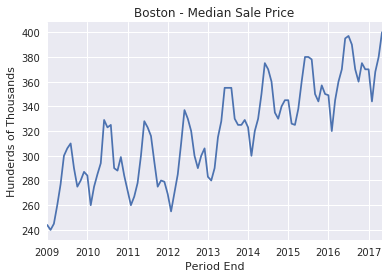

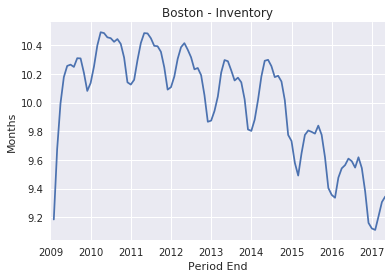

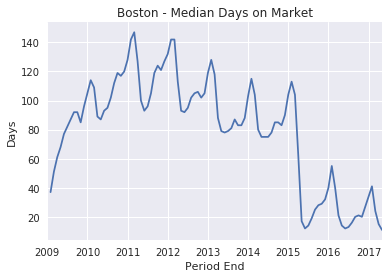

In [406]:
a['Boston, MA metro area All Residential Median Sale Price'].plot(title='Boston - Median Sale Price')
plt.ylabel('Hunderds of Thousands')
plt.figure()
a['Boston, MA metro area All Residential Inventory'].plot(title='Boston - Inventory')
plt.ylabel('Months')
plt.figure()
a['Boston, MA metro area All Residential Median Dom'].plot(title='Boston - Median Days on Market')
plt.ylabel('Days')
plt.figure()

# playing with graphs for the presentation/seasonality differences across metros vs nationwide

In [44]:
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


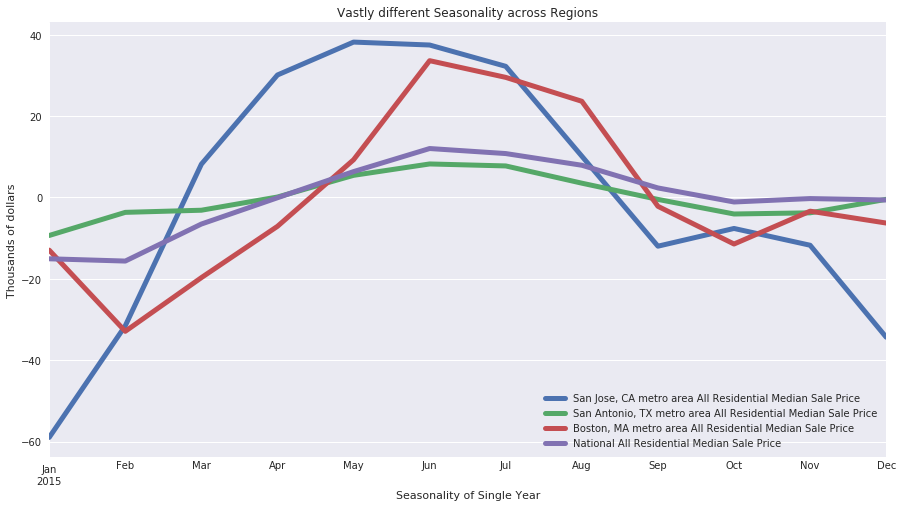

In [228]:
df_orig = df.copy()
df_orig = subset(df_orig,'All Residential')
df_orig = subset(df_orig,'Median Sale Price$')
df_orig = df_orig.dropna(axis=1)

for col in df_orig.columns:
    if 'San Jose' in col or 'Boston' in col or 'San Antonio' in col:
        col_decomp = sm.tsa.seasonal_decompose(df_orig[col],two_sided=False)
        trend_seas_pred = (col_decomp.trend+col_decomp.seasonal)
        trend_seas = (col_decomp.seasonal)
        trend_seas['2015'].plot(figsize=(15,8),title=col,legend=col,linewidth=5)

#df_nat = read_data(raw)
df_nat = rawless[rawless['Region'] == ' National']
df_nat = df_nat[df_nat['Property Type'] == 'All Residential']
#df_nat['Median Sale Price'].plot()

col_decomp = sm.tsa.seasonal_decompose(df_nat['Median Sale Price'],two_sided=False)
trend_seas = (col_decomp.seasonal)
trend_seas.name = 'National All Residential Median Sale Price'
trend_seas['2015'].plot(figsize=(15,8),title='Vastly different Seasonality across Regions',legend='National',linewidth=5)
plt.xlabel('Seasonality of Single Year')
plt.ylabel('Thousands of dollars')

# figure out how to do dynamic forecasts ahead

# time periods

In [46]:
end_first_3_years = '2011-08-31'
start_middle_3_years = '2011-09-30'
end_middle_3_years = '2014-04-30'
start_last_3_years = '2014-05-31'
start_last_6_years = '2011-09-30'

time_list = [end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years]

In [47]:
#raw.groupby('Region').agg(lambda x: x.count().sum())['Median Sale Price']
#raw.groupby(['Region']).

In [48]:
city_list = ['Austin, TX metro area',
 'Boston, MA metro area',
 'Buffalo, NY metro area',
 'Chicago, IL metro area',
 'Cleveland, OH metro area',
 'Dallas-Fort Worth, TX metro area',
 'Houston, TX metro area',
# 'Jacksonville, FL metro area',
 'Kansas City, MO metro area',
 'Las Vegas, NV metro area',
 'Los Angeles, CA metro area',
# 'Louisville, KY metro area',
# 'Memphis, TN metro area',
 'Miami, FL metro area',
# 'Milwaukee, WI metro area',
 'Oakland, CA metro area',
# 'Oklahoma City, OK metro area', errors out
 'Philadelphia, PA metro area',
 'Phoenix, AZ metro area',
 'Pittsburgh, PA metro area',
 'Portland, OR metro area',
 'Providence, RI metro area',
 'San Francisco, CA metro area']

city_holdout_list = [
# 'Sacramento, CA metro area', errors out
 'Salt Lake City, UT metro area',
 'San Antonio, TX metro area',
 'San Diego, CA metro area',
 'San Jose, CA metro area',
 'Seattle, WA metro area',
 'Tampa, FL metro area',
 'Washington, DC metro area',
 'Indianapolis, IN metro area',
 'Orlando, FL metro area'
# 'Cincinnati, OH metro area',
# ' National',
# 'Birmingham, AL metro area',
# 'Nashville, TN metro area',
# 'New Orleans, LA metro area',
# 'Riverside-San Bernardino, CA metro area',
# 'St. Louis, MO metro area']
            ]

In [49]:
len(city_list)

18

# impute something

In [50]:
[city for city in city_list]

['Austin, TX metro area',
 'Boston, MA metro area',
 'Buffalo, NY metro area',
 'Chicago, IL metro area',
 'Cleveland, OH metro area',
 'Dallas-Fort Worth, TX metro area',
 'Houston, TX metro area',
 'Kansas City, MO metro area',
 'Las Vegas, NV metro area',
 'Los Angeles, CA metro area',
 'Miami, FL metro area',
 'Oakland, CA metro area',
 'Philadelphia, PA metro area',
 'Phoenix, AZ metro area',
 'Pittsburgh, PA metro area',
 'Portland, OR metro area',
 'Providence, RI metro area',
 'San Francisco, CA metro area']

In [51]:
from fancyimpute import KNN, NuclearNormMinimization
def impute_knn(df, num_k):
    knn_array = KNN(k=num_k).complete(df)
    df_knn = pd.DataFrame(knn_array, columns=df.columns, index=df.index)
    return df_knn

ImportError: No module named 'fancyimpute'

In [52]:
df = impute_knn(df,5)

NameError: name 'impute_knn' is not defined

# collect all best arma error

In [53]:
def ARIMA3(df_orig,target,city_df,resid_df,time_list,param,steps=1):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #target
    y_last_6 = df_orig[start_last_6_years:][target]
    #setup test/train
    series = df_orig[target].copy()
    series = series.astype('float64')
    train, test = series[:start_middle_3_years], series[start_middle_3_years:]
    print(train)
    print(test)
    #setup hist
    history = [x for x in train]
    predictions = list()
    #pred for each month, allowing x steps out of sample prediction
    for i in test.index:
        model = sm.tsa.statespace.SARIMAX(history,order=(5,2,0))#,enforce_stationarity=False)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast(steps=steps)[steps-1]
        print(yhat)
        predictions.append(yhat)

    y_pred = pd.Series(predictions)
    y_pred.index = test.index
    #arma prediction
    best_arma_pred_last_6 = y_pred
    best_arma_pred_last_6.name = target+' Best ARIMA '+str(param)+' T+'+str(steps)
    #arma residual from target
    best_arma_resid_last_6 = (y_last_6 - best_arma_pred_last_6)
    best_arma_resid_last_6.name = target+' Best ARIMA Resid'
    #save pred
    if y_last_6.name in city_df.columns:
        city_df = pd.concat([city_df,best_arma_pred_last_6],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_6,best_arma_pred_last_6],axis=1)        
    resid_df = pd.concat([resid_df,best_arma_resid_last_6],axis=1)
    return city_df, resid_df, best_arma_pred_last_3

In [54]:
def blah(series,param=(5,2,0),steps=1):
    from pandas import Series
    from sklearn.metrics import mean_squared_error
    # from statsmodels.tsa.arima_model import ARIMA
    import statsmodels.api as sm
    from math import sqrt
    # load data
    #series = df_orig[target].copy()
    #series = df['Austin, TX metro area All Residential Median Sale Price']
    series = series.astype('float64')
    # prepare data
    # X = series.values
    # X = X.astype('float32')
    # train_size = int(len(X) * 0.50)
    # train, test = X[0:train_size], X[train_size:]
    train = series[:start_middle_3_years]
    test = series[start_middle_3_years:]

    # walk-forward validation
    history = [x for x in train]
    #print(history)
    predictions = list()
    # predictions = pd.Series()
    # for i in range(len(test)):
    for i in test.index:
        # predict
        model = sm.tsa.statespace.SARIMAX(history,order=param,enforce_stationarity=False)
        model_fit = model.fit(disp=0)
        #steps=3
        yhat = model_fit.forecast(steps=steps)[steps-1]
    #    yhat = model_fit.forecast()[0][0]
        #print(yhat)
        predictions.append(yhat)
        # observation
        obs = test[i]
        history.append(obs)
        #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    # report performance
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)
    return predictions

In [55]:
def blahs(series,param=(0,1,11),param_seasonal=(1,1,1,12),steps=1):
    from pandas import Series
    from sklearn.metrics import mean_squared_error
    # from statsmodels.tsa.arima_model import ARIMA
    import statsmodels.api as sm
    from math import sqrt
    # load data
    #series = df_orig[target].copy()
    #series = df['Austin, TX metro area All Residential Median Sale Price']
    series = series.astype('float64')
    # prepare data
    # X = series.values
    # X = X.astype('float32')
    # train_size = int(len(X) * 0.50)
    # train, test = X[0:train_size], X[train_size:]
    train = series[:start_middle_3_years]
    test = series[start_middle_3_years:]

    # walk-forward validation
    history = [x for x in train]
    #print(history)
    predictions = list()
    # predictions = pd.Series()
    # for i in range(len(test)):
    for i in test.index:
        # predict
        model = sm.tsa.statespace.SARIMAX(history,order=param,seasonal_order=param_seasonal,enforce_stationarity=False)
        model_fit = model.fit(disp=0)
        #steps=3
        yhat = model_fit.forecast(steps=steps)[steps-1]
    #    yhat = model_fit.forecast()[0][0]
        #print(yhat)
        predictions.append(yhat)
        # observation
        obs = test[i]
        history.append(obs)
        #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    # report performance
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)
    return predictions

In [56]:
def ARIMA4(df_orig,target,city_df,resid_df,time_list,param,steps=1):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #target
    y_last_6 = df_orig[start_last_6_years:][target]
    #setup test/train
    series = df_orig[target]
    predictions = blah(series,param,steps)
    y_pred = pd.Series(predictions)
    y_pred.index = test.index
    #arma prediction
    best_arma_pred_last_6 = y_pred
    best_arma_pred_last_6.name = target+' Best ARIMA '+str(param)+' T+'+str(steps)
    #arma residual from target
    best_arma_resid_last_6 = (y_last_6 - best_arma_pred_last_6)
    best_arma_resid_last_6.name = target+' Best ARIMA Resid'
    #last 3
    best_arma_pred_last_3 = best_arma_pred_last_6[start_last_3_years:]
    #save pred
    if y_last_6.name in city_df.columns:
        city_df = pd.concat([city_df,best_arma_pred_last_6],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_6,best_arma_pred_last_6],axis=1)        
    resid_df = pd.concat([resid_df,best_arma_resid_last_6],axis=1)
    return city_df, resid_df, best_arma_pred_last_3

In [57]:
def SARIMA4(df_orig,target,city_df,time_list,param,param_seasonal,steps=1):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #target
    y_last_6 = df_orig[start_last_6_years:][target]
    #setup test/train
    series = df_orig[target]
    predictions = blahs(series,param=param,param_seasonal=param_seasonal,steps=steps)
    y_pred = pd.Series(predictions)
    y_pred.index = test.index
    #sarma prediction
    best_sarma_pred_last_6 = y_pred
    best_sarma_pred_last_6.name = target+' Best SARMA '+str(param)+' T+'+str(steps)
    best_sarma_pred_mid_3 = best_sarma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_sarma_pred_last_3 = y_pred[start_last_3_years:]
    best_sarma_pred_last_3.name = target+' Best SARMA '+str(param)
    #target
    y_last_6 = df_orig[start_middle_3_years:][target]
    #save pred
    if y_last_6.name in city_df.columns:
        city_df = pd.concat([city_df,best_sarma_pred_last_6],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_6,best_sarma_pred_last_6],axis=1)  
    #save pred
#     city_df = pd.concat([city_df,best_sarma_pred_last_3],axis=1)
    return city_df

In [58]:
%%time
from pandas import Series
from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from math import sqrt
# load data
#series = df_orig[target].copy()
series = df['San Francisco, CA metro area All Residential Median Sale Price']
series = series.astype('float64')
# prepare data
# X = series.values
# X = X.astype('float32')
# train_size = int(len(X) * 0.50)
# train, test = X[0:train_size], X[train_size:]
train = series[:start_middle_3_years]
test = series[start_middle_3_years:]

# walk-forward validation
history = [x for x in train]
print(history)
predictions = list()
# predictions = pd.Series()
# for i in range(len(test)):
for i in test.index:
    # predict
    model = sm.tsa.statespace.SARIMAX(history,order=(9,2,0),enforce_stationarity=False)
    model_fit = model.fit(disp=0)
    steps=1
    yhat = model_fit.forecast(steps=steps)[steps-1]
#    yhat = model_fit.forecast()[0][0]
    #print(yhat)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

[561.0, 600.0, 590.0, 625.0, 650.0, 687.0, 666.0, 654.0, 650.0, 670.0, 664.0, 675.0, 629.0, 629.0, 695.0, 697.0, 676.0, 710.0, 700.0, 692.0, 656.0, 663.0, 691.0, 639.0, 575.0, 560.0, 650.0, 641.0, 690.0, 682.0, 664.0, 643.0, 616.0]
RMSE: 54.283
CPU times: user 3.16 s, sys: 3.05 s, total: 6.21 s
Wall time: 3.24 s


# create city_dict, 4 predictions per train city

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


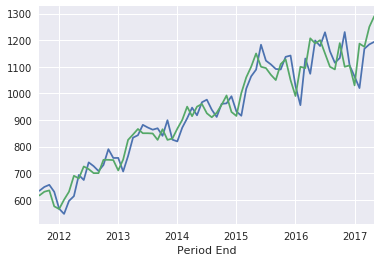

In [59]:
y_pred_t1 = pd.Series(predictions)
y_pred_t1.index = test.index
y_pred_t1.plot()
# y_pred_t2 = pd.Series(predictions)
# y_pred_t2.index = test.index
#y_pred_t2.plot()
df[start_middle_3_years:]['San Francisco, CA metro area All Residential Median Sale Price'].plot()

In [ ]:
#city_list = city_list[:1]

# Sarima
RMSE: 4.919
RMSE: 6.119
RMSE: 8.098
RMSE: 39.604
CPU times: user 51.2 s, sys: 32.1 s, total: 1min 23s
Wall time: 48.8 s

2,1,0 - 1,0,0,12

In [ ]:
%%time
city_dict = {}

for city in city_list:
    target = city+' All Residential Median Sale Price'
    #print(target)
    df_orig = df.copy()
    df_orig = subset(df_orig,city)
    df_orig = subset(df_orig,'All Residential') #remove to make it across all housing types
    df_orig = df_orig.dropna(axis=1)
    
    #build empty containers
    city_df = pd.DataFrame()
    resid_df = pd.DataFrame()

    #get preds last 6
    city_df,resid_df,best_arma_pred_last_3 = ARIMA4(df_orig,target,city_df,resid_df,time_list,param=(15,2,0),steps=1)
    city_df,resid_df,best_arma_pred_last_3 = ARIMA4(df_orig,target,city_df,resid_df,time_list,param=(15,2,0),steps=2)
    city_df,resid_df,best_arma_pred_last_3 = ARIMA4(df_orig,target,city_df,resid_df,time_list,param=(15,2,0),steps=3)
#     city_df,resid_df,best_arma_pred_last_3 = ARMA2(df_orig,target,city_df,resid_df,time_list,param=(17,2,0))
#     city_df = SARMA2(df_orig,target,city_df,time_list,param=(0,1,11),param_seasonal=(1,1,1,12))
    city_df = SARIMA4(df_orig,target,city_df,time_list,param=(1,1,0),param_seasonal=(1,1,0,12),steps=1)
    city_df = SARIMA4(df_orig,target,city_df,time_list,param=(1,1,0),param_seasonal=(1,1,0,12),steps=2)
    city_df = SARIMA4(df_orig,target,city_df,time_list,param=(1,1,0),param_seasonal=(1,1,0,12),steps=3)
    city_df = DECOMP2(df_orig,target,city_df,time_list)
    
#     naive = df_orig[target].shift(1)
#     naive.name = target+' Naive Baseline'
#     city_df = pd.concat([city_df,naive],axis=1)

    #city
    city_df = city_df.dropna(how='all')
    city_dict[city] = city_df

/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 12.018


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 9.827


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 9.535
RMSE: 5.101
RMSE: 6.964
RMSE: 9.993


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 12.745


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 20.038


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 28.623
RMSE: 10.048
RMSE: 18.311
RMSE: 27.274


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 5.522


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 6.807


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 7.415
RMSE: 4.835
RMSE: 6.187
RMSE: 8.766


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 8.022


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 10.413


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 16.521
RMSE: 6.080
RMSE: 10.764
RMSE: 17.446


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 16.059


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 39.993


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 123.655
RMSE: 7.738
RMSE: 11.423
RMSE: 15.558


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 5.833


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 7.611


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 9.094
RMSE: 4.581
RMSE: 6.810
RMSE: 9.114


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 12.054


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 15.005


/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

RMSE: 18.680


In [ ]:
for city in city_list[-4:]:
    city_dict[city].plot()

# create city_resid_dict, 4 model residuals per city

In [ ]:
city_resid_dict = {}
for city in city_list:
    resid_df = pd.DataFrame()
    for i in range(len(city_dict[city].columns)):
        error = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i])
        error.name = city_dict[city].iloc[:,i].name+' Pred Error'
        resid_df = pd.concat([resid_df,error],axis=1)
        resid_df = resid_df.dropna()
#         if i != 0:
#             error = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i])
#             error.name = city_dict[city].iloc[:,i].name+' Pred Error'
#             resid_df = pd.concat([resid_df,error],axis=1)
#             resid_df = resid_df.dropna()
#         else:
#             error = (city_dict[city].iloc[:,0])
#             error.name = city_dict[city].iloc[:,i].name+' Supervised Target'
#             resid_df = pd.concat([resid_df,error],axis=1)
#             resid_df = resid_df.dropna()
    city_resid_dict[city] = resid_df
    #    city_resid_dict[city].append((city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i]))

In [ ]:
city_resid_dict[city]

# create model_resid_dict, 18 city residuals per model

In [60]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  # or whatever

In [61]:
model_resid_dict = {}
#create dataframes
supervised_target_df = pd.DataFrame()
best_arma_error_df = pd.DataFrame()
best_sarma_error_df = pd.DataFrame()
trend_error_df = pd.DataFrame()
trend_seas_error_df = pd.DataFrame()

for city in city_list:  
    #create 
    prefix = city+' All Residential '
    old_cols = [col for col in city_resid_dict[city].columns]
    models = []
    for old_col in old_cols:
        models.append(remove_prefix(old_col,prefix))
    
    #make model dfs [if adding more models need to add htem here!]
    #supervised_target_df = pd.concat([supervised_target_df,city_resid_dict[city].iloc[:,0]],axis=1)
    best_arma_error_df = pd.concat([best_arma_error_df,city_resid_dict[city].iloc[:,1]],axis=1)
    best_sarma_error_df = pd.concat([best_sarma_error_df,city_resid_dict[city].iloc[:,2]],axis=1)
    trend_error_df = pd.concat([trend_error_df,city_resid_dict[city].iloc[:,3]],axis=1)
    trend_seas_error_df = pd.concat([trend_seas_error_df,city_resid_dict[city].iloc[:,4]],axis=1)
#     naive_baseline_df = pd.concat([naive_baseline_df,city_resid_dict[city].iloc[:,5]],axis=1)
    
#model_resid_dict[models[0]] = supervised_target_df    
model_resid_dict[models[1]] = best_arma_error_df
model_resid_dict[models[2]] = best_sarma_error_df
model_resid_dict[models[3]] = trend_error_df
model_resid_dict[models[4]] = trend_seas_error_df
# model_resid_dict[models[5]] = naive_baseline_df  

NameError: name 'city_resid_dict' is not defined

In [ ]:
for model in [model for model in models[1:]]:
    print(model)

# mod the supervised function

In [62]:
def create_supervised2(df,term):    
    bos = df.copy()
    target = term #[col for col in bos.columns if re.findall(term+'$',col)][0]
    #print(target)
    #target = 'Median Sale Price'
    for col in [col for col in bos.columns if col != target]:
        if term not in col:
            for t in range(0,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
        else:
            for t in range(1,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
    
    for f in range(1,4):
        bos[target+' T+'+str(f)] = bos[target].shift(-f)

    bos.drop(target,axis=1,inplace=True) 
    bos = bos.dropna(axis=0)
    return bos

# create model_train_dict, supervised data for each model

In [ ]:
models[7:]

In [ ]:
model_train_dict = {}
for model in models[1:]:
    master_model_resid_df = pd.DataFrame()
    for city in city_list:
        df_sup = pd.DataFrame()
        
        target = [col for col in city_resid_dict[city] if model in col][0]
        print(target)
        df_orig = df.copy()
        df_orig = subset(df_orig,city)
        df_orig = subset(df_orig,'All Residential')
        df_orig = df_orig.dropna(axis=1)

        resid_df = pd.concat([df_orig,city_resid_dict[city][target]],axis=1)#.dropna(axis=0)
        df_sup = create_supervised2(resid_df,target)

        #remove names
        prefix = city+' All Residential ' # or city+' ' when doing all housing types
        old_cols = [col for col in df_sup.columns]
        new_cols =[]
        rename_dict = {}
        for old_col in old_cols:
            rename_dict[old_col] = remove_prefix(old_col,prefix)
            new_cols.append(old_col.strip(prefix))
        df_sup = df_sup.rename(columns=rename_dict)
        master_model_resid_df = pd.concat([master_model_resid_df,df_sup],axis=0)
        master_model_resid_df = master_model_resid_df.dropna(axis=0)
    model_train_dict[model] = master_model_resid_df


In [ ]:
models = list(model_train_dict.keys())
models

In [ ]:
#model_train_dict['Median Sale Price Best ARMA (15, 2, 0) Pred Error'].head()

# pickle these results

In [ ]:
import pickle

pickle.dump(city_dict, open("city_dict4.p", "wb"))
pickle.dump(city_resid_dict, open("city_resid_dict4.p", "wb"))
pickle.dump(model_resid_dict, open("model_resid_dict4.p", "wb"))
pickle.dump(model_train_dict, open("model_train_dict4.p", "wb"))

In [ ]:
import pickle

# pickle.dump(city_dict, open("city_all_housing_t123_dict.p", "wb"))
# pickle.dump(city_resid_dict, open("city_all_housing_t123_resid_dict.p", "wb"))
# pickle.dump(model_resid_dict, open("model_all_housing_t123_resid_dict.p", "wb"))
# pickle.dump(model_train_dict, open("model_all_housing_t123_train_dict.p", "wb"))

# resave the pickles without -inf

In [ ]:
# for city in city_list:
#     df = city_dict[city].copy()
#     for col in df.columns:
#         df[col] = df[col].replace(-np.inf,np.nan)
#         df[col] = df[col].replace(np.nan,df[col].min())
#     city_dict[city] = df
    
# for city in city_list:
#     df = city_resid_dict[city].copy()
#     for col in df.columns:
#         df[col] = df[col].replace(-np.inf,np.nan)
#         df[col] = df[col].replace(np.nan,df[col].min())
#     city_resid_dict[city] = df
    
# for model in models:
#     df = model_resid_dict[model].copy()
#     for col in df.columns:
#         df[col] = df[col].replace(-np.inf,np.nan)
#         df[col] = df[col].replace(np.nan,df[col].min())
#     model_resid_dict[model] = df
    
# for model in models:
#     df = model_train_dict[model].copy()
#     for col in df.columns:
#         df[col] = df[col].replace(-np.inf,np.nan)
#         df[col] = df[col].replace(np.nan,df[col].min())
#     model_train_dict[model] = df

In [63]:
import pickle

# pickle.dump(city_dict, open("city_all_housing_dict.p", "wb"))
# pickle.dump(city_resid_dict, open("city_all_housing_resid_dict.p", "wb"))
# pickle.dump(model_resid_dict, open("model_all_housing_resid_dict.p", "wb"))
# pickle.dump(model_train_dict, open("model_all_housing_train_dict.p", "wb"))
# city_dict = pickle.load(open("city_dict4.p", "rb"))
# city_resid_dict = pickle.load(open("city_resid_dict4.p", "rb"))

# original train cities, without T+2 or T+3

In [ ]:
# city_dict = pickle.load(open("city_dict.p", "rb"))
# city_resid_dict = pickle.load(open("city_resid_dict.p", "rb"))
# model_resid_dict = pickle.load(open("model_resid_dict.p", "rb"))
# model_train_dict = pickle.load(open("model_train_dict.p", "rb"))

# original train cities, but with gidsearched sarma, and T+2 and T+3

In [ ]:
# city_dict = pickle.load(open("city_dict2.p", "rb"))
# city_resid_dict = pickle.load(open("city_resid_dict2.p", "rb"))
# model_resid_dict = pickle.load(open("model_resid_dict2.p", "rb"))
# model_train_dict = pickle.load(open("model_train_dict2.p", "rb"))

# train cities, all housing types:

In [ ]:
# city_dict = pickle.load(open("city_all_housing_dict.p", "rb"))
# city_resid_dict = pickle.load(open("city_all_housing_resid_dict.p", "rb"))
# model_resid_dict = pickle.load(open("model_all_housing_resid_dict.p", "rb"))
# model_train_dict = pickle.load(open("model_all_housing_train_dict.p", "rb"))

# train cities, all housing types, T+1, T+2 and T+3:

In [ ]:
# city_dict = pickle.load(open("city_all_housing_t123_dict.p", "rb"))
# city_resid_dict = pickle.load(open("city_all_housing_t123_resid_dict.p", "rb"))
# model_resid_dict = pickle.load(open("model_all_housing_t123_resid_dict.p", "rb"))
# model_train_dict = pickle.load(open("model_all_housing_t123_train_dict.p", "rb"))

# reload to run T+2 and T+3 again

In [44]:
import pickle
city_dict = pickle.load(open("./orig_data/city_dict4.p", "rb"))
city_resid_dict = pickle.load(open("./orig_data/city_resid_dict4.p", "rb"))
model_resid_dict = pickle.load(open("./orig_data/model_resid_dict4.p", "rb"))
model_train_dict = pickle.load(open("./orig_data/model_train_dict4.p", "rb"))

ModuleNotFoundError: No module named 'pandas.tseries.index'

In [43]:
import sys
# 1
import pandas.core.indexes 
sys.modules['pandas.indexes'] = pandas.core.indexes
# 2
import pandas.core.base, pandas.core.indexes.frozen
setattr(sys.modules['pandas.core.base'],'FrozenNDArray', pandas.core.indexes.frozen.FrozenNDArray)

In [42]:
import _pickle as cPickle
with open('./orig_data/city_dict4.p', 'rb') as fo:
    dict = cPickle.load(fo, encoding='latin1')

ModuleNotFoundError: No module named 'pandas.indexes'

In [37]:
pd.read_pickle("./orig_data/city_dict4.p", "rb")

ValueError: Unrecognized compression type: rb
Valid compression types are ['infer', None, 'bz2', 'gzip', 'xz', 'zip']

# remove duplicate arima T+Xs because of how this is constructed now there are duplicates when creating the other T+Xs

In [236]:
#T+3
dropf = 'T+1 Pred Error T+3'
dropd = 'T+1 Pred Error T+2'
dropk = 'T+2 Pred Error T+1'
dropc = 'T+2 Pred Error T+2'
dropa = 'T+2 Pred Error T+3'
dropb = 'T+3 Pred Error T+1'
dropl = 'T+3 Pred Error T+2'
drope = 'T+3 Pred Error T+3'
dropg = 'Seasonality Pred Error T+3'
droph = 'Seasonality Pred Error T+2'
dropi = 'Trend Pred Error T+3'
dropj = 'Trend Pred Error T+2'

# #T+3
# drope = 'T+1 Pred Error T+1'
# dropf = 'T+1 Pred Error T+3'
# dropd = 'T+1 Pred Error T+2'
# dropk = 'T+2 Pred Error T+1'
# dropc = 'T+2 Pred Error T+2'
# dropa = 'T+2 Pred Error T+3'
# dropb = 'T+3 Pred Error T+1'
# dropl = 'T+3 Pred Error T+2'
# dropg = 'Seasonality Pred Error T+1'
# droph = 'Seasonality Pred Error T+2'
# dropi = 'Trend Pred Error T+1'
# dropj = 'Trend Pred Error T+2'

#T+2
# drope = 'T+1 Pred Error T+1'
# dropf = 'T+1 Pred Error T+3'
# dropd = 'T+1 Pred Error T+2'
# dropk = 'T+2 Pred Error T+1'
# dropc = 'T+2 Pred Error T+3'
# dropa = 'T+3 Pred Error T+3'
# dropb = 'T+3 Pred Error T+1'
# dropl = 'T+3 Pred Error T+2'
# dropg = 'Seasonality Pred Error T+1'
# droph = 'Seasonality Pred Error T+3'
# dropi = 'Trend Pred Error T+1'
# dropj = 'Trend Pred Error T+3'

models = list(model_train_dict.keys())
for model in models:
    for col in [col for col in model_train_dict[model].columns 
                if dropa in col 
                or dropb in col 
                or dropc in col 
                or dropd in col 
                or drope in col 
                or dropf in col
                or dropg in col 
                or droph in col
                or dropi in col 
                or dropj in col
                or dropk in col 
                or dropl in col]:
        print(col)
        model_train_dict[model].drop(col,axis=1,inplace=True)

Median Sale Price Best ARIMA (15, 2, 0) T+3 Pred Error T+1
Median Sale Price Best ARIMA (15, 2, 0) T+3 Pred Error T+2
Median Sale Price Best ARIMA (15, 2, 0) T+3 Pred Error T+3
Median Sale Price Best SARMA (1, 1, 0) T+3 Pred Error T+1
Median Sale Price Best SARMA (1, 1, 0) T+3 Pred Error T+2
Median Sale Price Best SARMA (1, 1, 0) T+3 Pred Error T+3
Median Sale Price Best ARIMA (15, 2, 0) T+2 Pred Error T+1
Median Sale Price Best ARIMA (15, 2, 0) T+2 Pred Error T+2
Median Sale Price Best ARIMA (15, 2, 0) T+2 Pred Error T+3
Median Sale Price Trend Seasonality Pred Error T+2
Median Sale Price Trend Seasonality Pred Error T+3
Median Sale Price Baseline Trend Pred Error T+2
Median Sale Price Baseline Trend Pred Error T+3
Median Sale Price Best ARIMA (15, 2, 0) T+1 Pred Error T+2
Median Sale Price Best ARIMA (15, 2, 0) T+1 Pred Error T+3
Median Sale Price Best SARMA (1, 1, 0) T+2 Pred Error T+1
Median Sale Price Best SARMA (1, 1, 0) T+2 Pred Error T+2
Median Sale Price Best SARMA (1, 1, 0) T

# drop whichever target column, here T+2, T+3 columns

In [237]:
# dropa = 'T+2'
# dropb = 'T+3'
# models = list(model_train_dict.keys())
# for model in models:
#     for col in [col for col in model_train_dict[model].columns if dropa in col or dropb in col]:
#         print(col)
#         model_train_dict[model].drop(col,axis=1,inplace=True)

In [238]:
models = list(model_train_dict.keys())
select_models = []
for model in models:
    for col in [col for col in model_train_dict[model].columns if 'T+1' in col]:
        select_models.append(model)
        print(col)

Median Sale Price Trend Seasonality Pred Error T+1
Median Sale Price Baseline Trend Pred Error T+1
Median Sale Price Best ARIMA (15, 2, 0) T+1 Pred Error T+1
Median Sale Price Best SARMA (1, 1, 0) T+1 Pred Error T+1


# all models trained on basic elasticnet

In [239]:
#df = model_train_dict['Median Sale Price Baseline Trend Pred Error'].copy()

t = 'T+1'
#trained_models_dict = {}
#for model in models:
for model in select_models:
    print(model+' '+t)
    df = model_train_dict[model].copy()
    target = [col for col in df.columns if t in col][0]
    X = df.drop([target],axis=1)
    y = df[target]

    #timewise
    X_train = X[start_middle_3_years:end_middle_3_years]
    y_train = y[start_middle_3_years:end_middle_3_years]
    X_test = X[end_middle_3_years:]
    y_test = y[end_middle_3_years:]

    #model
    reg = ElasticNet(l1_ratio=.7) # .73
    #reg = LinearSVR(C=5, epsilon=1) #best for unscaled data reg = LinearSVR(C=.07, epsilon=4) #.48 trend

    #model fit
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    
    #model score
    print(r2_score(y_test,y_pred))
        
    #model
    importance = pd.DataFrame(list(zip(X.columns,reg.coef_)))
    importance.columns = ['col','coef']
    importance = importance.sort_values(by='coef',ascending=False).head(50)
    
    trained_models_dict[model+' '+t] = {'model':reg.fit(X_train,y_train),'coefs':importance}

Median Sale Price Trend Seasonality Pred Error T+1


/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.366763659136
Median Sale Price Baseline Trend Pred Error T+1
0.713230716246
Median Sale Price Best ARIMA (15, 2, 0) T+1 Pred Error T+1
-0.4490266136
Median Sale Price Best SARMA (1, 1, 0) T+1 Pred Error T+1
-0.589130092758


In [ ]:
trained_models_dict.keys()
# trained_models_dict[model]['model'].predict(X_test)
# trained_models_dict[model]['coefs'].head()

In [240]:
pickle.dump(trained_models_dict, open("trained_models_dict5.p", "wb")) #trained on X_train, y_train as opposed to X,y
#model_train_dict = pickle.load(open("model_train_dict3.p", "rb"))

# add predicted error to holdout cities

In [65]:
df = pd.read_csv('./clean_top50.csv')
df['Period End'] = pd.to_datetime(df['Period End'])
df = df.set_index('Period End')
df = impute_knn(df,5)

NameError: name 'impute_knn' is not defined

In [ ]:
#%%time
hold_city_dict = {}

for city in city_holdout_list:
    target = city+' All Residential Median Sale Price'
    #print(target)
    df_orig = df.copy()
    df_orig = subset(df_orig,city)
    df_orig = subset(df_orig,'All Residential')
    df_orig = df_orig.dropna(axis=1)
    
    #build empty containers
    city_df = pd.DataFrame()
    resid_df = pd.DataFrame()

    #get preds last 6
#     city_df,resid_df,best_arma_pred_last_3 = ARMA2(df_orig,target,city_df,resid_df,time_list,param=(15,2,0))
#     city_df = SARMA2(df_orig,target,city_df,time_list,param=(0,1,11),param_seasonal=(1,1,1,12))
    city_df,resid_df,best_arma_pred_last_3 = ARIMA4(df_orig,target,city_df,resid_df,time_list,param=(15,2,0),steps=1)
    city_df,resid_df,best_arma_pred_last_3 = ARIMA4(df_orig,target,city_df,resid_df,time_list,param=(15,2,0),steps=2)
    city_df,resid_df,best_arma_pred_last_3 = ARIMA4(df_orig,target,city_df,resid_df,time_list,param=(15,2,0),steps=3)
    city_df = SARIMA4(df_orig,target,city_df,time_list,param=(1,1,0),param_seasonal=(1,1,0,12),steps=1)
    city_df = SARIMA4(df_orig,target,city_df,time_list,param=(1,1,0),param_seasonal=(1,1,0,12),steps=2)
    city_df = SARIMA4(df_orig,target,city_df,time_list,param=(1,1,0),param_seasonal=(1,1,0,12),steps=3)
    city_df = DECOMP2(df_orig,target,city_df,time_list)
#     naive = df_orig[target].shift(1)
#     naive.name = target+' Naive Baseline'
#     city_df = pd.concat([city_df,naive],axis=1)

    #city
    city_df = city_df.dropna(how='all')
    hold_city_dict[city] = city_df

In [ ]:
hold_city_resid_dict = {}
for city in city_holdout_list:
    resid_df = pd.DataFrame()
    for i in range(len(hold_city_dict[city].columns)):
        error = (hold_city_dict[city].iloc[:,0] - hold_city_dict[city].iloc[:,i])
        error.name = hold_city_dict[city].iloc[:,i].name+' Pred Error'
        resid_df = pd.concat([resid_df,error],axis=1)
        resid_df = resid_df.dropna()
    hold_city_resid_dict[city] = resid_df
    #    city_resid_dict[city].append((city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i]))

In [ ]:
hold_city_resid_dict[city].columns

In [ ]:
hold_model_resid_dict = {}
#create dataframes
best_arma_error_df = pd.DataFrame()
best_sarma_error_df = pd.DataFrame()
trend_error_df = pd.DataFrame()
trend_seas_error_df = pd.DataFrame()

for city in ['Orlando, FL metro area']:#city_holdout_list:  
    #create 
    prefix = city+' All Residential '
    old_cols = [col for col in hold_city_resid_dict[city].columns]
    models = []
    for old_col in old_cols:
        models.append(remove_prefix(old_col,prefix))
    
    #make model dfs [if adding more models need to add htem here!]
    best_arma_error_t1_df = pd.concat([best_arma_error_t1_df,hold_city_resid_dict[city].iloc[:,1]],axis=1)
    best_arma_error_t2_df = pd.concat([best_arma_error_t2_df,hold_city_resid_dict[city].iloc[:,2]],axis=1)
    best_arma_error_t3_df = pd.concat([best_arma_error_t3_df,hold_city_resid_dict[city].iloc[:,3]],axis=1)
    best_sarma_error_t1_df = pd.concat([best_sarma_error_t1_df,hold_city_resid_dict[city].iloc[:,4]],axis=1)
    best_sarma_error_t2_df = pd.concat([best_sarma_error_t2_df,hold_city_resid_dict[city].iloc[:,5]],axis=1)
    best_sarma_error_t3_df = pd.concat([best_sarma_error_t3_df,hold_city_resid_dict[city].iloc[:,6]],axis=1)
    trend_error_df = pd.concat([trend_error_df,hold_city_resid_dict[city].iloc[:,7]],axis=1)
    trend_seas_error_df = pd.concat([trend_seas_error_df,hold_city_resid_dict[city].iloc[:,8]],axis=1)
#     naive_baseline_error_df = pd.concat([trend_seas_error_df,hold_city_resid_dict[city].iloc[:,5]],axis=1)

    
#correct name (models has pred error at loc 0)
hold_model_resid_dict[models[1]] = best_arma_error_t1_df
hold_model_resid_dict[models[2]] = best_arma_error_t2_df
hold_model_resid_dict[models[3]] = best_arma_error_t3_df
hold_model_resid_dict[models[4]] = best_sarma_error_t1_df
hold_model_resid_dict[models[5]] = best_sarma_error_t2_df
hold_model_resid_dict[models[6]] = best_sarma_error_t3_df
hold_model_resid_dict[models[7]] = trend_error_df
hold_model_resid_dict[models[8]] = trend_seas_error_df
# hold_model_resid_dict[models[5]] = naive_baseline_error_df

In [ ]:
hold_model_resid_dict[models[2]]

# predict residual from trained model above, remember which T+ used

In [ ]:
hold_city_resid_dict[city]

In [66]:
# pickle.dump(hold_city_dict, open("hold_city_dict.p", "wb"))
# pickle.dump(hold_model_resid_dict, open("hold_model_resid_dict.p", "wb"))
# pickle.dump(hold_city_resid_dict, open("hold_city_resid_dict.p", "wb"))
hold_model_resid_dict = pickle.load(open("hold_model_resid_dict.p", "rb"))
hold_city_resid_dict = pickle.load(open("hold_city_resid_dict.p", "rb"))
hold_city_dict = pickle.load(open("hold_city_dict.p", "rb"))

# drop cols T+2 and T+3

In [67]:
dropa = 'T+2'
dropb = 'T+3'
for city in city_holdout_list:
    for col in [col for col in hold_city_resid_dict[city].columns if dropa in col or dropb in col]:
#        print(col)
        hold_city_resid_dict[city].drop(col,axis=1,inplace=True)
        
for city in city_holdout_list:
    for col in [col for col in hold_city_dict[city].columns if dropa in col or dropb in col]:
#        print(col)
        hold_city_dict[city].drop(col,axis=1,inplace=True)

In [68]:
#models = list(trained_models_dict.keys())
[model for model in models if dropa not in model and dropb not in model]
#list(trained_models_dict.keys())

NameError: name 'models' is not defined

In [ ]:
models

In [69]:
models = [col for col in hold_city_resid_dict[city] if 'Pred Error' in col]

In [70]:
[model for model in models if dropa not in model and dropb not in model]

['Orlando, FL metro area All Residential Median Sale Price Pred Error',
 'Orlando, FL metro area All Residential Median Sale Price Best ARIMA (15, 2, 0) T+1 Pred Error',
 'Orlando, FL metro area All Residential Median Sale Price Best SARMA (1, 1, 0) T+1 Pred Error',
 'Orlando, FL metro area All Residential Median Sale Price Baseline Trend Pred Error',
 'Orlando, FL metro area All Residential Median Sale Price Trend Seasonality Pred Error']

In [71]:
t = 'T+1'
model_pred_dict = {}
for model in [model for model in models if dropa not in model and dropb not in model][1:]:
    master_model_pred_df = pd.DataFrame()
    for city in city_holdout_list:
        df_sup = pd.DataFrame()
        
        target = [col for col in hold_city_resid_dict[city] if model in col][0]
        print(target+' '+t)
        df_orig = df.copy()
        df_orig = subset(df_orig,city)
        df_orig = subset(df_orig,'All Residential')
        df_orig = df_orig.dropna(axis=1)

        pred_df = pd.concat([df_orig,hold_city_resid_dict[city][target]],axis=1)#.dropna(axis=0)
        df_sup = create_supervised2(pred_df,target)

#         df_sup = df_sup.drop(target+' T+1',axis=1)
        df_sup = df_sup.drop(target+' T+2',axis=1)
        df_sup = df_sup.drop(target+' T+3',axis=1)
        
        X = df_sup.drop(target+' T+1',axis=1)
        
        y_pred = trained_models_dict[model+' '+t]['model'].predict(X)
        y_pred = pd.Series(y_pred)
        y_pred.index = X.index
        y_pred.name = city+' All Residential '+model+' Error Prediction'
        
        master_model_pred_df = pd.concat([master_model_pred_df,y_pred],axis=1)
#        master_model_pred_df = master_model_pred_df.dropna(axis=0)
    model_pred_dict[model+' '+t] = master_model_pred_df


IndexError: list index out of range

# confirm pred looks like its working

In [72]:
df_sup[target+' T+1'].plot()
y_pred.plot()

NameError: name 'target' is not defined

In [73]:
#models = list(model_pred_dict.keys())
hold_city_y_dict = {}
for city in city_holdout_list:
    city_df = pd.DataFrame()
    for model in [model for model in models if dropa not in model and dropb not in model][1:]:
        col = [col for col in model_pred_dict[model+' '+t] if city in col][0]
        city_df = pd.concat([city_df,model_pred_dict[model+' '+t][col]],axis=1)
    hold_city_y_dict[city] = city_df

KeyError: 'Orlando, FL metro area All Residential Median Sale Price Best ARIMA (15, 2, 0) T+1 Pred Error T+1'

# add naive baseline in here

In [ ]:
add = ' Add T+1'
naive = ' Naive Baseline T+1'
naive_shift = 1 #NEEEEED to change this

hold_city_add_dict = {}
for city in city_holdout_list:
    best_arma_add = pd.DataFrame()
    best_sarma_add = pd.DataFrame()
    trend_add = pd.DataFrame()
    trend_seas_add = pd.DataFrame()
    group_add = pd.DataFrame()
    
    best_arma_add = (hold_city_dict[city].iloc[:,1] - hold_city_y_dict[city].iloc[:,0])
    best_arma_add.name = hold_city_dict[city].iloc[:,1].name+add
    best_sarma_add = (hold_city_dict[city].iloc[:,2] + hold_city_y_dict[city].iloc[:,1])
    best_sarma_add.name = hold_city_dict[city].iloc[:,2].name+add
    trend_add = (hold_city_dict[city].iloc[:,3] + hold_city_y_dict[city].iloc[:,2])
    trend_add.name = hold_city_dict[city].iloc[:,3].name+add
    trend_seas_add = (hold_city_dict[city].iloc[:,4] + hold_city_y_dict[city].iloc[:,3])
    trend_seas_add.name = hold_city_dict[city].iloc[:,4].name+add
    naive_baseline = (hold_city_dict[city].iloc[:,0].shift(naive_shift))
    naive_baseline.name = hold_city_dict[city].iloc[:,0].name+naive
    
    group_add = pd.concat([group_add,hold_city_dict[city]],axis=1)
    group_add = pd.concat([group_add,best_arma_add,best_sarma_add,trend_add,trend_seas_add,naive_baseline],axis=1)
    hold_city_add_dict[city] = group_add

In [ ]:
hold_city_add_dict[city]

In [ ]:
for i in range(len(hold_city_add_dict[city].columns)):
    print(hold_city_add_dict[city].iloc[:,i].name)
    print(np.sqrt((hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,i])**2).sum())

In [ ]:
best_ARMA_df = pd.DataFrame()
best_ARMA_add_df = pd.DataFrame()
best_SARMA_df = pd.DataFrame()
best_SARMA_add_df = pd.DataFrame()
trend_df = pd.DataFrame()
trend_add_df = pd.DataFrame()
trend_seasonality_df = pd.DataFrame()
trend_seasonality_add_df = pd.DataFrame()
naive_baseline_df = pd.DataFrame()

hold_model_error_dict = {}
hold_city_error_dict = {}

for city in city_holdout_list:
    city_error_df = pd.DataFrame()

    #calc error for each city's 6 models
    city_best_ARMA_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,1])
    city_best_ARMA_resid.name = hold_city_add_dict[city].iloc[:,1].name+' Error'
    city_best_ARMA_add_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,5])
    city_best_ARMA_add_resid.name = hold_city_add_dict[city].iloc[:,5].name+' Error'
    city_best_SARMA_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,2])
    city_best_SARMA_resid.name = hold_city_add_dict[city].iloc[:,2].name+' Error'
    city_best_SARMA_add_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,6])
    city_best_SARMA_add_resid.name = hold_city_add_dict[city].iloc[:,6].name+' Error'
    city_trend_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,3])
    city_trend_resid.name = hold_city_add_dict[city].iloc[:,3].name+' Error'
    city_trend_add_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,7])
    city_trend_add_resid.name = hold_city_add_dict[city].iloc[:,7].name+' Error'
    city_trend_seasonality_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,4])
    city_trend_seasonality_resid.name = hold_city_add_dict[city].iloc[:,4].name+' Error'
    city_trend_seasonality_add_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,8])
    city_trend_seasonality_add_resid.name = hold_city_add_dict[city].iloc[:,8].name+' Error'
#     city_naive_baseline_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,0].shift(-1))
#     city_naive_baseline_resid.name = hold_city_add_dict[city].iloc[:,0].name+' Error'
    city_naive_baseline_resid = (hold_city_add_dict[city].iloc[:,0] - hold_city_add_dict[city].iloc[:,9])
    city_naive_baseline_resid.name = hold_city_add_dict[city].iloc[:,0].name+' Naive Baseline Error'

    #add error to a city error df
    errors = [city_best_ARMA_resid,
              city_best_ARMA_add_resid,
              city_best_SARMA_resid,
              city_best_SARMA_add_resid,
              city_trend_resid,
              city_trend_add_resid,
              city_trend_seasonality_resid,
              city_trend_seasonality_add_resid,
              city_naive_baseline_resid]
    city_error_df = pd.concat(errors,axis=1)
    hold_city_error_dict[city] = city_error_df

    #add error to model df for each city
    best_ARMA_df = pd.concat([best_ARMA_df,city_best_ARMA_resid],axis=1)
    best_ARMA_add_df = pd.concat([best_ARMA_add_df,city_best_ARMA_add_resid],axis=1)
    best_SARMA_df = pd.concat([best_SARMA_df,city_best_SARMA_resid],axis=1)
    best_SARMA_add_df = pd.concat([best_SARMA_add_df,city_best_SARMA_add_resid],axis=1)
    trend_df = pd.concat([trend_df,city_trend_resid],axis=1)
    trend_add_df = pd.concat([trend_add_df,city_trend_add_resid],axis=1)
    trend_seasonality_df = pd.concat([trend_seasonality_df,city_trend_seasonality_resid],axis=1)
    trend_seasonality_add_df = pd.concat([trend_seasonality_add_df,city_trend_seasonality_add_resid],axis=1)
    naive_baseline_df = pd.concat([naive_baseline_df,city_naive_baseline_resid],axis=1)
    

#add to a model dictionary
hold_model_error_dict['Best ARIMA Error'] = best_ARMA_df
hold_model_error_dict['Best ARIMA Add Error'] = best_ARMA_add_df
hold_model_error_dict['Best SARIMA Error'] = best_SARMA_df
hold_model_error_dict['Best SARIMA Add Error'] = best_SARMA_add_df
hold_model_error_dict['Trend Error'] = trend_df
hold_model_error_dict['Trend Add Error'] = trend_add_df
hold_model_error_dict['Trend Seasonality Error'] = trend_seasonality_df
hold_model_error_dict['Trend Seasonality Add Error'] = trend_seasonality_add_df
hold_model_error_dict['Naive Baseline'] = naive_baseline_df

In [ ]:
hold_model_error_dict['Naive Baseline']

# save for each timeforecast

In [ ]:
#td
# pickle.dump(hold_city_add_dict, open("hold_city_add_dict_t1.p", "wb"))
# pickle.dump(hold_city_error_dict, open("hold_city_error_dict_t1.p", "wb"))
# pickle.dump(hold_model_error_dict, open("hold_model_error_dict_t1.p", "wb"))

#td
# pickle.dump(hold_city_add_dict, open("hold_city_add_dict_t2.p", "wb"))
# pickle.dump(hold_city_error_dict, open("hold_city_error_dict_t2.p", "wb"))
# pickle.dump(hold_model_error_dict, open("hold_model_error_dict_t2.p", "wb"))

#saved
# pickle.dump(hold_city_add_dict, open("hold_city_add_dict_t3.p", "wb"))
# pickle.dump(hold_city_error_dict, open("hold_city_error_dict_t3.p", "wb"))
# pickle.dump(hold_model_error_dict, open("hold_model_error_dict_t3.p", "wb"))

# visual for predicting leftover

In [156]:
hold_city_error_dict_t3 = pickle.load(open("hold_city_error_dict_t3.p", "rb"))

In [157]:
hold_city_error_dict_t3['Washington, DC metro area'].head(1)

,"Washington, DC metro area All Residential Median Sale Price Best ARIMA (15, 2, 0) T+3 Error","Washington, DC metro area All Residential Median Sale Price Best ARIMA (15, 2, 0) T+3 Add T+3 Error","Washington, DC metro area All Residential Median Sale Price Best SARMA (1, 1, 0) T+3 Error","Washington, DC metro area All Residential Median Sale Price Best SARMA (1, 1, 0) T+3 Add T+3 Error","Washington, DC metro area All Residential Median Sale Price Baseline Trend Error","Washington, DC metro area All Residential Median Sale Price Baseline Trend Add T+3 Error","Washington, DC metro area All Residential Median Sale Price Trend Seasonality Error","Washington, DC metro area All Residential Median Sale Price Trend Seasonality Add T+3 Error","Washington, DC metro area All Residential Median Sale Price Naive Baseline Error"
Period End,,,,,,,,,
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


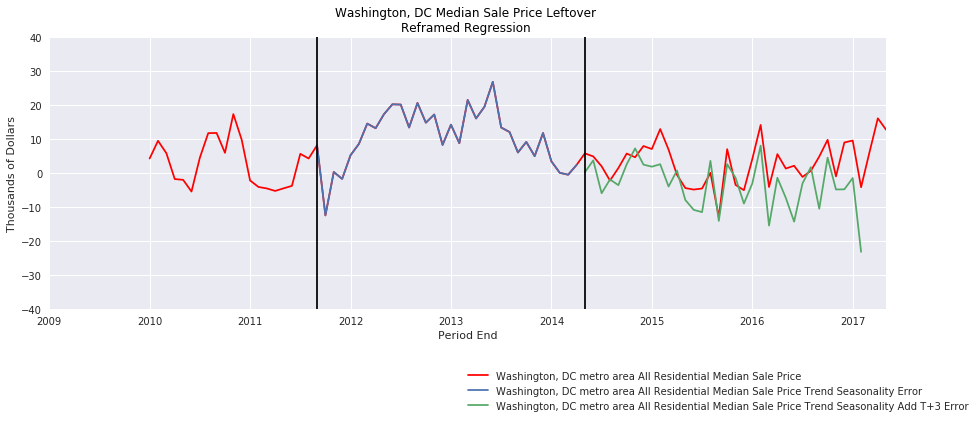

In [163]:
#dc_msp = hold_city_add_dict_t1['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price']
dc_ts = hold_city_error_dict_t3['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price Trend Seasonality Error']
dc_tsa = hold_city_error_dict_t3['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price Trend Seasonality Add T+3 Error']

f = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((100,100), (0, 0), colspan=300, rowspan=150)
#plot(df_orig,'Median Sale Price')
#dc_msp.plot()
col_decomp = sm.tsa.seasonal_decompose(dc_msp,two_sided=False)
col_decomp.resid.plot(color='red',title='Leftover Component')
plt.ylabel('Thousands of Dollars')
plt.ylim((-40,40))
dc_ts[start_middle_3_years:end_middle_3_years].plot()
dc_tsa[start_last_3_years:].plot()
#col_decomp.trend.plot()
plt.title('Washington, DC Median Sale Price Leftover \nReframed Regression ',loc='center', color='black')
#d.plot(kind='bar', ax=f.gca())
plt.legend(loc='center', bbox_to_anchor=(.8, -.3))#1.1
#plt.legend(bbox_to_anchor=(0.65,1))
xposition = [pd.to_datetime('2011-09-30'), pd.to_datetime('2014-05-31')]
for xc in xposition:
    ax1.axvline(x=xc, color='k', linestyle='-')
plt.show()

# EDA for pres

In [170]:
bos = subset(df,'Boston, MA metro area')
bos = subset(bos,'All Residential')

In [199]:
bos.columns

Index(['Boston, MA metro area All Residential Avg Sale To List',
       'Boston, MA metro area All Residential Avg Sale To List Mom',
       'Boston, MA metro area All Residential Avg Sale To List Yoy',
       'Boston, MA metro area All Residential Homes Sold',
       'Boston, MA metro area All Residential Homes Sold Mom',
       'Boston, MA metro area All Residential Homes Sold Yoy',
       'Boston, MA metro area All Residential Inventory',
       'Boston, MA metro area All Residential Inventory Mom',
       'Boston, MA metro area All Residential Inventory Yoy',
       'Boston, MA metro area All Residential Median Dom',
       'Boston, MA metro area All Residential Median Dom Mom',
       'Boston, MA metro area All Residential Median Dom Yoy',
       'Boston, MA metro area All Residential Median List Ppsf',
       'Boston, MA metro area All Residential Median List Ppsf Mom',
       'Boston, MA metro area All Residential Median List Ppsf Yoy',
       'Boston, MA metro area All Resident

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


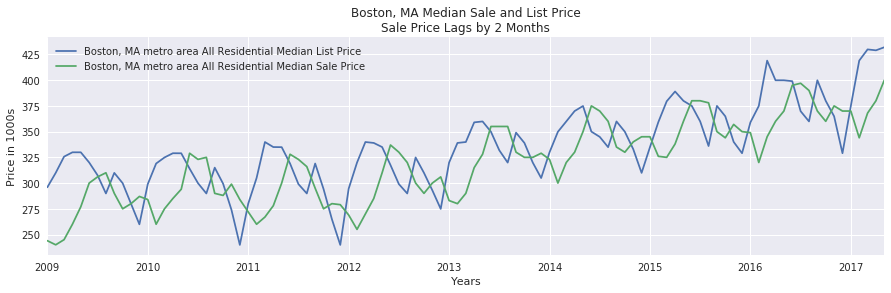

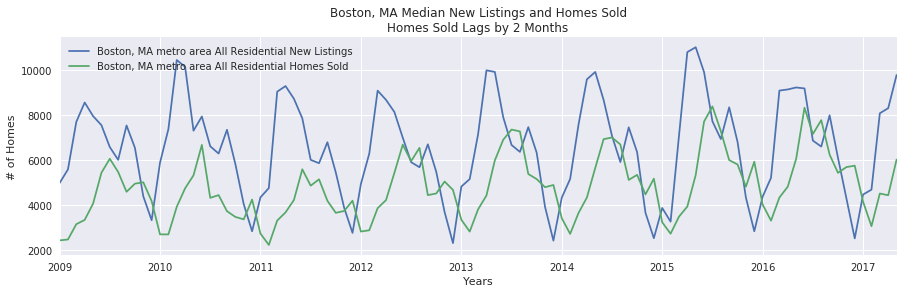

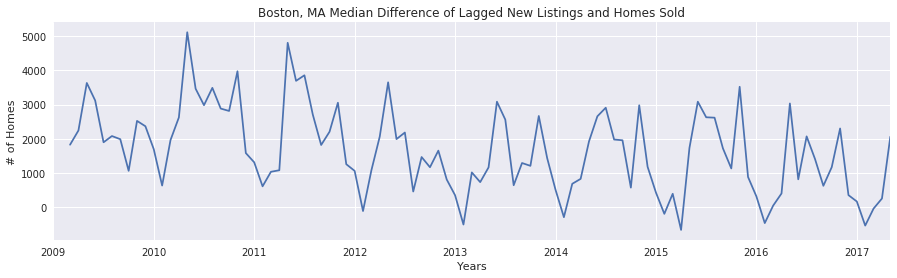

In [224]:
# bos['Boston, MA metro area All Residential Inventory'].plot(figsize=(15,4))
# plt.ylabel('Months')
# plt.xlabel('Years')
# plt.figure()
# bos['Boston, MA metro area All Residential Median Dom'].plot(title='',figsize=(15,4))
# plt.ylabel('Months')
# plt.xlabel('Years')
# plt.figure()
bos['Boston, MA metro area All Residential Median List Price'].plot(
    title='Boston, MA Median Sale and List Price\nSale Price Lags by 2 Months'
    ,figsize=(15,4))
bos['Boston, MA metro area All Residential Median Sale Price'].plot(title='',figsize=(15,4))
plt.legend()
plt.ylabel('Price in 1000s')
plt.xlabel('Years')
plt.figure()
# bos['Boston, MA metro area All Residential Sold Above List'].plot(title='',figsize=(15,4))
# plt.figure()
# bos['Boston, MA metro area All Residential Median Dom'].plot(title='Boston, MA metro area\nAverage Sale to List',figsize=(15,4))
# plt.legend()
# plt.ylabel('Percent')
# plt.xlabel('Years')
# plt.figure()
# (bos['Boston, MA metro area All Residential Median Sale Price']*1000/bos['Boston, MA metro area All Residential Median Ppsf']).plot(title='',figsize=(15,4))
# plt.legend()
# plt.ylabel('Median Sqft')
# plt.xlabel('Years')
# plt.figure()
bos['Boston, MA metro area All Residential New Listings'].plot(
    title='Boston, MA Median New Listings and Homes Sold\nHomes Sold Lags by 2 Months'
    ,figsize=(15,4))
# bos['Boston, MA metro area All Residential New Listings'].shift(2).plot(
#     title='Boston, MA Median New Listings and Homes Sold\nHomes Sold Lags by 2 Months'
#     ,figsize=(15,4))
bos['Boston, MA metro area All Residential Homes Sold'].plot(title='',figsize=(15,4))
plt.legend()
plt.ylabel('# of Homes')
plt.xlabel('Years')
plt.figure()
(bos['Boston, MA metro area All Residential New Listings'].shift(2)-bos['Boston, MA metro area All Residential Homes Sold']).plot(
    title='Boston, MA Median Difference of Lagged New Listings and Homes Sold'
    ,figsize=(15,4))
#bos['Boston, MA metro area All Residential Homes Sold'].plot(title='',figsize=(15,4))
plt.ylabel('# of Homes')
plt.xlabel('Years')
plt.figure()


# visual for train/test split

In [131]:
hold_city_add_dict_t1 = pickle.load(open("hold_city_add_dict_t1.p", "rb"))
hold_city_add_dict_t2 = pickle.load(open("hold_city_add_dict_t2.p", "rb"))
hold_city_add_dict_t3 = pickle.load(open("hold_city_add_dict_t3.p", "rb"))

In [112]:
dc_msp = df['Washington, DC metro area All Residential Median Sale Price']

In [115]:
bos = subset(df,'Boston, MA metro area')
bos = subset(bos,'All Residential')

In [135]:
hold_city_add_dict_t3['Washington, DC metro area'].head(1)

,"Washington, DC metro area All Residential Median Sale Price","Washington, DC metro area All Residential Median Sale Price Best ARIMA (15, 2, 0) T+3","Washington, DC metro area All Residential Median Sale Price Best SARMA (1, 1, 0) T+3","Washington, DC metro area All Residential Median Sale Price Baseline Trend","Washington, DC metro area All Residential Median Sale Price Trend Seasonality","Washington, DC metro area All Residential Median Sale Price Best ARIMA (15, 2, 0) T+3 Add T+3","Washington, DC metro area All Residential Median Sale Price Best SARMA (1, 1, 0) T+3 Add T+3","Washington, DC metro area All Residential Median Sale Price Baseline Trend Add T+3","Washington, DC metro area All Residential Median Sale Price Trend Seasonality Add T+3","Washington, DC metro area All Residential Median Sale Price Naive Baseline T+3"
Period End,,,,,,,,,,
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


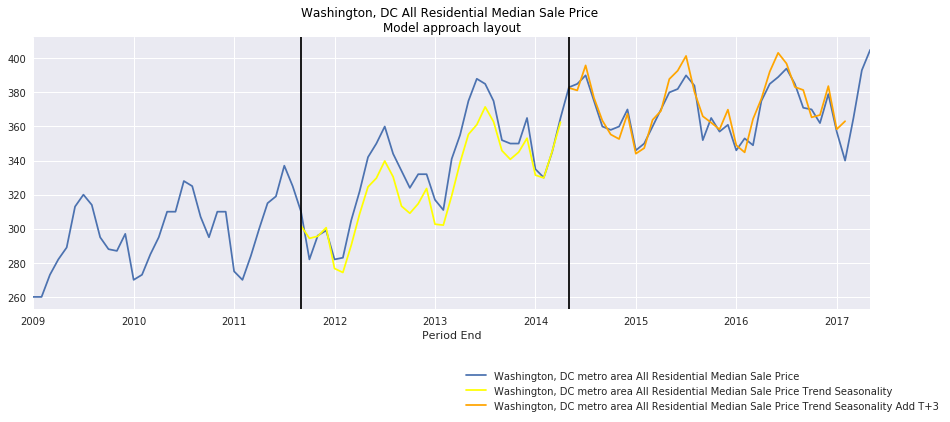

In [169]:
#dc_msp = hold_city_add_dict_t1['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price']
dc_ts = hold_city_add_dict_t3['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price Trend Seasonality']
dc_tsa = hold_city_add_dict_t3['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price Trend Seasonality Add T+3']

f = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((100,100), (0, 0), colspan=300, rowspan=150)
#plot(df_orig,'Median Sale Price')
dc_msp.plot()
dc_ts[start_middle_3_years:end_middle_3_years].plot(color='yellow')
dc_tsa[start_last_3_years:].plot(color='orange')
#col_decomp.trend.plot()
plt.title('Washington, DC All Residential Median Sale Price \nModel approach layout',loc='center', color='black')
#d.plot(kind='bar', ax=f.gca())
plt.legend(loc='center', bbox_to_anchor=(.8, -.3))#1.1
#plt.legend(bbox_to_anchor=(0.65,1))
xposition = [pd.to_datetime('2011-09-30'), pd.to_datetime('2014-05-31')]
for xc in xposition:
    ax1.axvline(x=xc, color='k', linestyle='-')
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


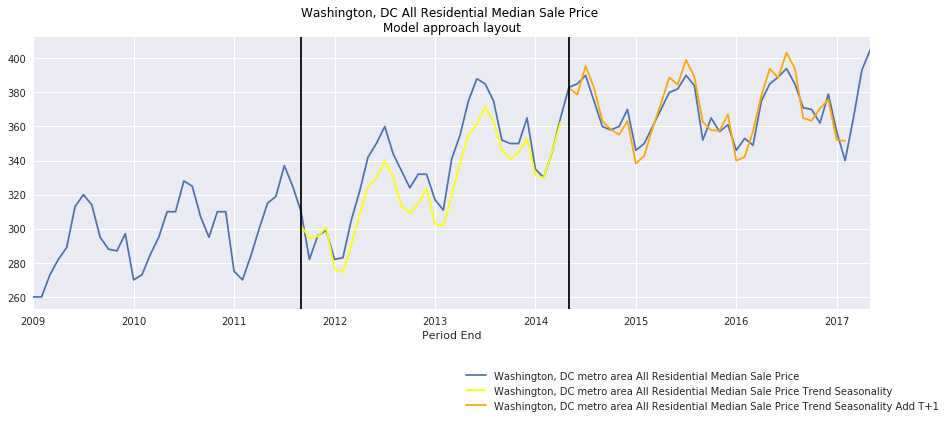

In [168]:
#dc_msp = hold_city_add_dict_t1['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price']
dc_ts = hold_city_add_dict_t1['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price Trend Seasonality']
dc_tsa = hold_city_add_dict_t1['Washington, DC metro area']['Washington, DC metro area All Residential Median Sale Price Trend Seasonality Add T+1']

f = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((100,100), (0, 0), colspan=300, rowspan=150)
#plot(df_orig,'Median Sale Price')
dc_msp.plot()
dc_ts[start_middle_3_years:end_middle_3_years].plot(color='yellow')
dc_tsa[start_last_3_years:].plot(color='orange')
#col_decomp.trend.plot()
plt.title('Washington, DC All Residential Median Sale Price \nModel approach layout',loc='center', color='black')
#d.plot(kind='bar', ax=f.gca())
plt.legend(loc='center', bbox_to_anchor=(.8, -.3))#1.1
#plt.legend(bbox_to_anchor=(0.65,1))
xposition = [pd.to_datetime('2011-09-30'), pd.to_datetime('2014-05-31')]
for xc in xposition:
    ax1.axvline(x=xc, color='k', linestyle='-')
plt.show()

In [ ]:
col_decomp = sm.tsa.seasonal_decompose(dc_msp,two_sided=False)
dc_msp.plot(figsize=(15,5),title='Washington, DC\nMedian Sale Price')
dc_msp.shift(3).plot(figsize=(15,5),title='Washington, DC\nNaive Baseline')
plt.ylim((250,410))
plt.ylabel('Thousands of Dollars')
plt.xlabel('Year')
plt.figure()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


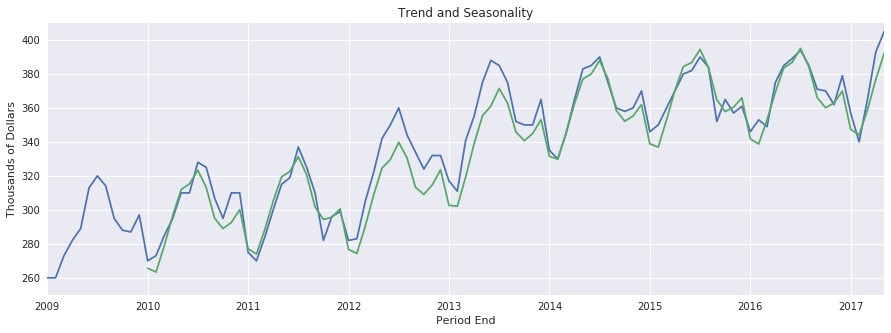

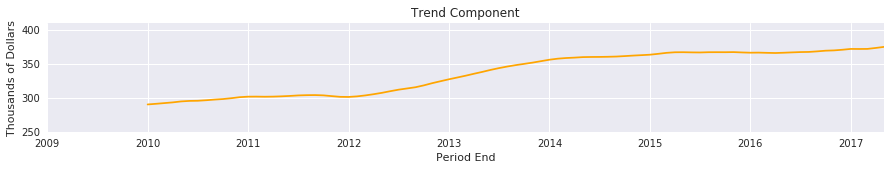

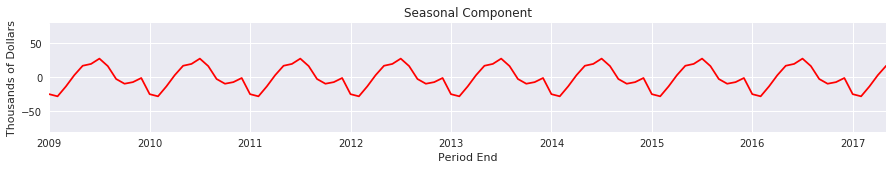

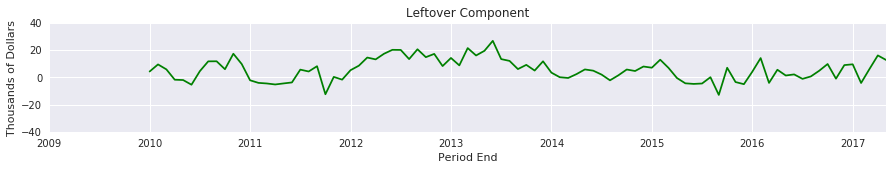

In [155]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

col_decomp = sm.tsa.seasonal_decompose(dc_msp,two_sided=False)
# dc_msp.plot(figsize=(15,5),title='Washington, DC\nMedian Sale Price')
# dc_msp.shift(3).plot(figsize=(15,5),title='Washington, DC\nNaive Baseline')
# plt.ylim((250,410))
# plt.ylabel('Thousands of Dollars')
# plt.xlabel('Year')
# plt.figure()
dc_msp.plot(figsize=(15,5),title='Washington, DC Median Sale Price')
# plt.ylim((250,410))
# plt.ylabel('Thousands of Dollars')
# plt.xlabel('Year')
# plt.figure()
(col_decomp.trend+col_decomp.seasonal).plot(figsize=(15,5),title='Trend and Seasonality')
plt.ylim((250,410))
plt.ylabel('Thousands of Dollars')
plt.figure()
(col_decomp.trend).plot(color='orange',figsize=(15,2),title='Trend Component')
plt.ylim((250,410))
plt.ylabel('Thousands of Dollars')
plt.figure()
col_decomp.seasonal.plot(color='red',figsize=(15,2),title='Seasonal Component')
plt.ylabel('Thousands of Dollars')
plt.ylim((-80,80))
plt.figure()
col_decomp.resid.plot(color='green',figsize=(15,2),title='Leftover Component')
plt.ylabel('Thousands of Dollars')
plt.ylim((-40,40))
plt.figure()
# col_decomp.resid[start_last_3_years:].plot(figsize=(5,5),title='Leftover')
# plt.ylabel('Thousands of Dollars')
# plt.ylim((-40,40))
# plt.figure()
# (col_decomp.trend+col_decomp.seasonal)[start_last_3_years:].plot(figsize=(5,5),title='Trend Seasonal')
# plt.ylabel('Thousands of Dollars')
# plt.ylim((250,410))

# look at each coef of trained model

In [74]:
trained_models_dict = pickle.load(open("trained_models_dict5.p", "rb"))
#model_train_dict = pickle.load(open("model_train_dict4.p", "rb"))

In [123]:
num = 7
coefs_t1 = trained_models_dict['Median Sale Price Trend Seasonality Pred Error T+1']['coefs'].sort_values(ascending=False,by='coef').head(num)
coefs_t2 = trained_models_dict['Median Sale Price Trend Seasonality Pred Error T+2']['coefs'].sort_values(ascending=False,by='coef').head(num)
coefs_t3 = trained_models_dict['Median Sale Price Trend Seasonality Pred Error T+3']['coefs'].sort_values(ascending=False,by='coef').head(num)
#model_train_dict['Median Sale Price Trend Seasonality Pred Error']['model']

In [124]:
coefs_t1 = coefs_t1.rename(columns = {'col':'Feature','coef':'T+1 coef'})
coefs_t2 = coefs_t2.rename(columns = {'col':'Feature','coef':'T+2 coef'})
coefs_t3 = coefs_t3.rename(columns = {'col':'Feature','coef':'T+3 coef'})

In [125]:
coefs_all = pd.concat([coefs_t1,coefs_t2,coefs_t3],axis=1)

In [126]:
coefs_all.fillna('')

,Feature,T+1 coef,Feature,T+2 coef,Feature,T+3 coef
168,Median List Ppsf T-0,0.169981,Median List Ppsf T-0,0.305249,Median List Ppsf T-0,0.266117
169,Median List Ppsf T-1,0.106041,,,,
210,Median List Price T-0,0.123348,Median List Price T-0,0.200818,Median List Price T-0,0.245818
211,Median List Price T-1,0.0961836,,,,
238,Median Ppsf T-0,0.115291,,,,
243,,,,,Median Ppsf T-5,0.100696
282,,,,,Median Sale Price T-2,0.133689
283,,,Median Sale Price T-3,0.175015,,
284,Median Sale Price T-4,0.170147,,,,
287,,,,,Median Sale Price T-7,0.0813467


# evaluate for each t

In [96]:
def rmse(col):
    return np.sqrt(col**2).mean()

def absoluteval(col):
    return np.abs(col).sum()

In [97]:
import pickle
hold_model_error_dict_t1 = pickle.load(open("hold_model_error_dict_t1.p", "rb"))
hold_model_error_dict_t2 = pickle.load(open("hold_model_error_dict_t2.p", "rb"))
hold_model_error_dict_t3 = pickle.load(open("hold_model_error_dict_t3.p", "rb"))

In [98]:
hold_model_error_dict_ts = {}
hold_model_error_dict_ts['T+1'] = hold_model_error_dict_t1
hold_model_error_dict_ts['T+2'] = hold_model_error_dict_t2
hold_model_error_dict_ts['T+3'] = hold_model_error_dict_t3

In [99]:
hold_model_error_dict_t1.keys()

dict_keys(['Naive Baseline', 'Best SARIMA Add Error', 'Best ARIMA Add Error', 'Trend Seasonality Add Error', 'Best ARIMA Error', 'Best SARIMA Error', 'Trend Error', 'Trend Seasonality Error', 'Trend Add Error'])

In [100]:
(hold_model_error_dict_ts[t]['Trend Seasonality Add Error'][start_last_3_years:].apply(rmse))#.mean()

Salt Lake City, UT metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error     4.273861
San Antonio, TX metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error        2.953824
San Diego, CA metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error          5.550502
San Jose, CA metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error          12.866854
Seattle, WA metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error            5.263301
Tampa, FL metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error              2.217731
Washington, DC metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error         5.924513
Indianapolis, IN metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error       3.137617
Orlando, FL metro area All Residential Median Sale Price Trend Seasonality Add T+1 Error            2.695716
dtype: float64

In [101]:
model_performance = {}
model_performance['T+1'] = {}
model_performance['T+2'] = {}
model_performance['T+3'] = {}
model_performance_rmse = {}
model_performance_rmse['T+1'] = {}
model_performance_rmse['T+2'] = {}
model_performance_rmse['T+3'] = {}
model_performance_abs = {}
model_performance_abs['T+1'] = {}
model_performance_abs['T+2'] = {}
model_performance_abs['T+3'] = {}

models = []
for model in list(hold_model_error_dict_t1.keys()):
    print(model)
    models.append(model)
    for t in list(hold_model_error_dict_ts.keys()):
        #print(t+': '+str(hold_model_error_dict_ts[t][model].apply(rmse).mean()))
        #print('{}: {}'.format(t,hold_model_error_dict_ts[t][model][start_last_3_years:].apply(rmse).mean()))
        model_performance[t][model] = hold_model_error_dict_ts[t][model][start_last_3_years:]
        #model_performance_abs[t][model].append(hold_model_error_dict_ts[t][model][start_last_3_years:].apply(rmse))
        model_performance_rmse[t][model] = hold_model_error_dict_ts[t][model][start_last_3_years:].apply(rmse).mean()
        model_performance_abs[t][model] = hold_model_error_dict_ts[t][model][start_last_3_years:].apply(absoluteval).mean()

Naive Baseline
Best SARIMA Add Error
Best ARIMA Add Error
Trend Seasonality Add Error
Best ARIMA Error
Best SARIMA Error
Trend Error
Trend Seasonality Error
Trend Add Error


In [102]:
%%javascript 
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [103]:
mp = pd.DataFrame(model_performance_rmse)
mp = mp.T
#mp.columns = list(hold_model_error_dict_t1.keys())
mp = mp[['Trend Seasonality Add Error', 'Trend Seasonality Error',
         'Best SARIMA Error', #'Best SARIMA Add Error', 
        'Best ARIMA Error', #'Best ARIMA Add Error', 
         #'Trend Add Error', 
         #'Trend Error',
         'Naive Baseline', 
       ]]

In [104]:
#mp[sorted(mp.columns)]
mp.sort_values(by='T+1',axis=1)

,Trend Seasonality Add Error,Best SARIMA Error,Best ARIMA Error,Naive Baseline,Trend Seasonality Error
T+1,4.987102,6.331809,7.363772,8.714715,12.259134
T+2,5.371972,8.433098,8.288797,12.621622,12.259134
T+3,5.661282,11.844310,10.968445,15.855856,12.259134


In [109]:
mp = mp.drop(['T+2','T+1'],axis=0)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


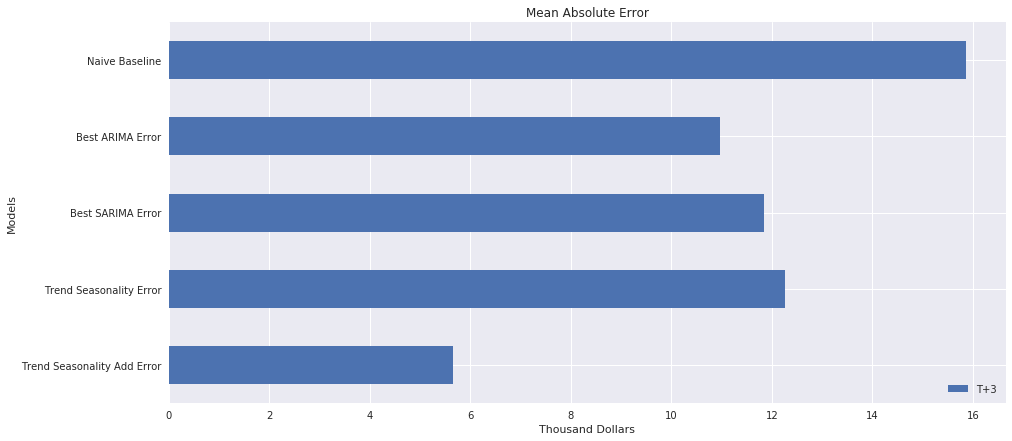

In [110]:
mp.T.plot(kind='barh',figsize=(15,7),title='Mean Absolute Error')
plt.xlabel('Thousand Dollars')
plt.ylabel('Models')

Forecasting 1 month out, the naive baseline prediction is off on average by ~8.71k
The 2nd best model's redictions are off on average ~6.33k
While the new Trend Seasonality Add model predictions are off by only 4.98k.

Imagine that small business transitioning from using a naive baseline to more accurate Trend Seasonality Add model when informing their decisions in a real estate flipping business. By using the new model they can be 3.7k more accurate entering and exiting from the market allowing them to potentially save 7k per transaction.

If they do 8-10 flips a year, which is an average volume for a small business, they could produce 56-70k of savings per year. Expanding to a 3 month out prediction, the company could save a whooping 140-200k in one year. 

# how much better threndline

- 47-68% better than naive baseline
- 57% better than trend baseline
- 27-56% better than best SARIMA
- 37-52% better than best ARIMA

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


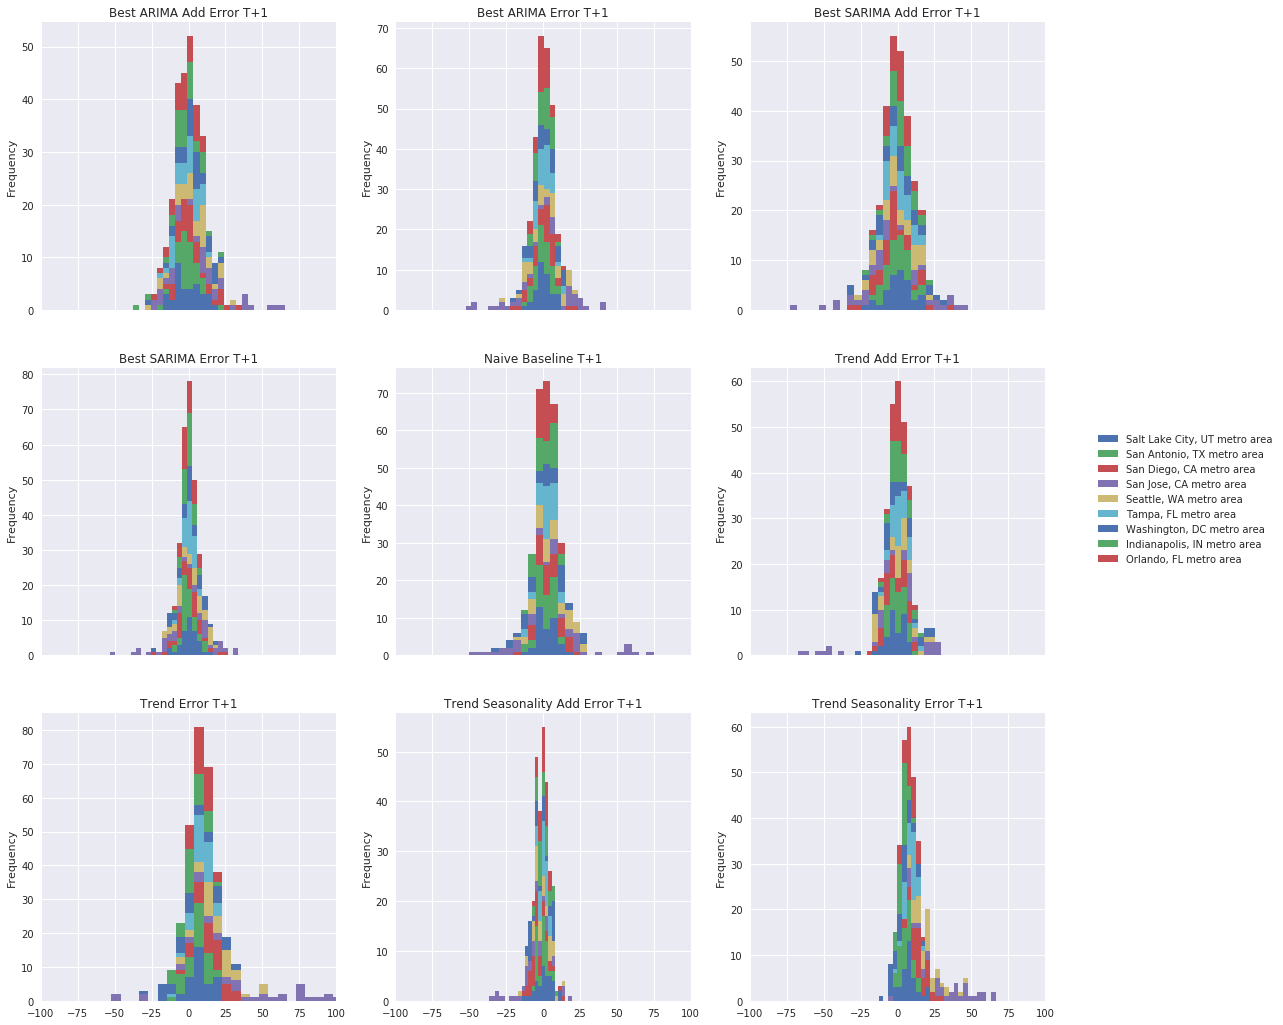

In [177]:
import re
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=3)

t = 'T+1'
for ax,model in zip(axes.reshape(-1),sorted(hold_model_error_dict_t1.keys())):
    if model == 'Best ARIMA Add Error':
        ax.set_xlim((-100,100))
        #ax.legend([city_holdout_list])
        model_performance[t][model].plot(legend=False,
                                        #legend=[city_holdout_list],
                                         sharex=True,stacked=True,bins=25,
                                         kind='hist',ax=ax,figsize=(18,18),title=model+' '+t)#.legend(bbox_to_anchor=(2.6, 1.6))
    else:
        ax.set_xlim((-100,100))
        model_performance[t][model].plot(legend=False,
                                         sharex=True,stacked=True,bins=25,
                                         kind='hist',ax=ax,figsize=(18,18),title=model+' '+t)
plt.legend(city_holdout_list,bbox_to_anchor=(1.8, 2))
#plt.legend(bbox_to_anchor=(2.6, 1.6))

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


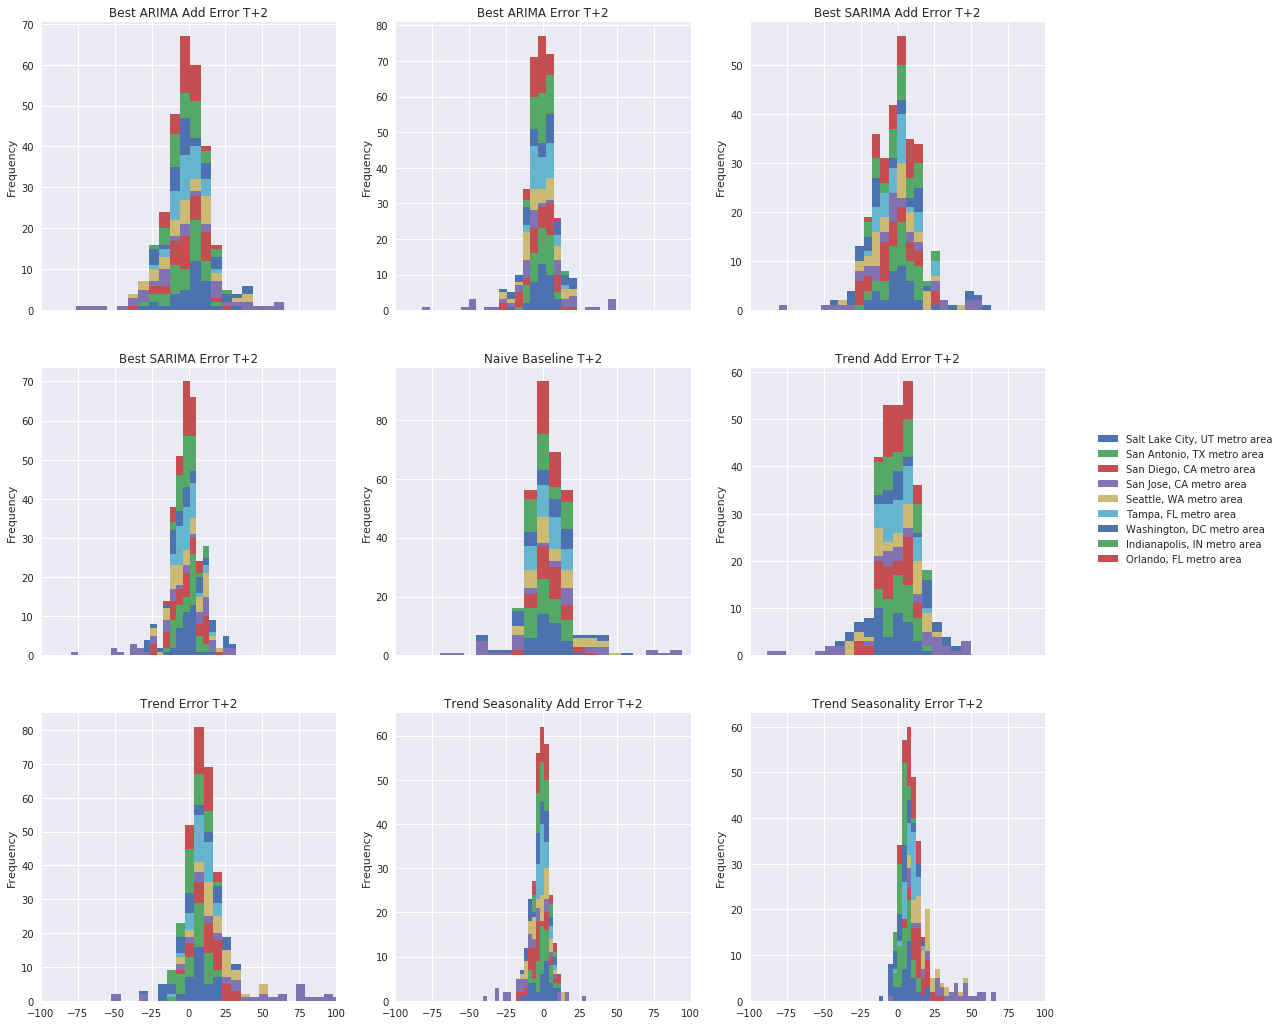

In [251]:
import re
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=3)

t = 'T+2'
for ax,model in zip(axes.reshape(-1),sorted(hold_model_error_dict_t1.keys())):
    if model == 'Best ARIMA Add Error':
        ax.set_xlim((-100,100))
        #ax.legend([city_holdout_list])
        model_performance[t][model].plot(legend=False,
                                        #legend=[city_holdout_list],
                                         sharex=True,stacked=True,bins=25,
                                         kind='hist',ax=ax,figsize=(18,18),title=model+' '+t)#.legend(bbox_to_anchor=(2.6, 1.6))
    else:
        ax.set_xlim((-100,100))
        model_performance[t][model].plot(legend=False,
                                         sharex=True,stacked=True,bins=25,
                                         kind='hist',ax=ax,figsize=(18,18),title=model+' '+t)
plt.legend(city_holdout_list,bbox_to_anchor=(1.8, 2))
#plt.legend(bbox_to_anchor=(2.6, 1.6))

import re
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=3)

t = 'T+3'
for ax,model in zip(axes.reshape(-1),sorted(hold_model_error_dict_t1.keys())):
    if model == 'Best ARIMA Add Error':
        ax.set_xlim((-100,100))
        #ax.legend([city_holdout_list])
        model_performance[t][model].plot(legend=False,
                                        #legend=[city_holdout_list],
                                         sharex=True,stacked=True,bins=25,
                                         kind='hist',ax=ax,figsize=(18,18),title=model+' '+t)#.legend(bbox_to_anchor=(2.6, 1.6))
    else:
        ax.set_xlim((-100,100))
        model_performance[t][model].plot(legend=False,
                                         sharex=True,stacked=True,bins=25,
                                         kind='hist',ax=ax,figsize=(18,18),title=model+' '+t)
plt.legend(city_holdout_list,bbox_to_anchor=(1.8, 2))
#plt.legend(bbox_to_anchor=(2.6, 1.6))

# distribution of error

Best ARIMA Error
Naive Baseline
Trend Error


KeyboardInterrupt: 

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


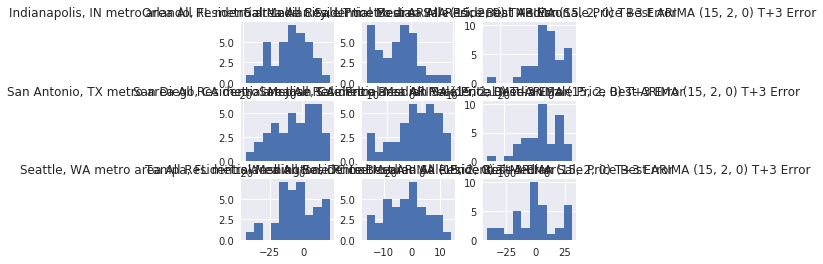

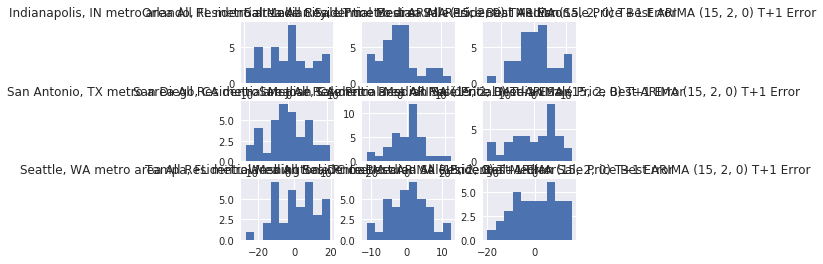

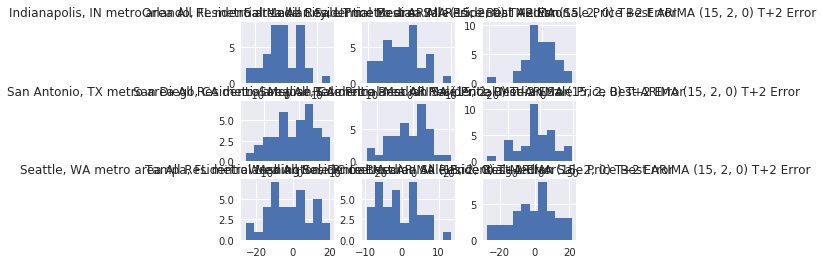

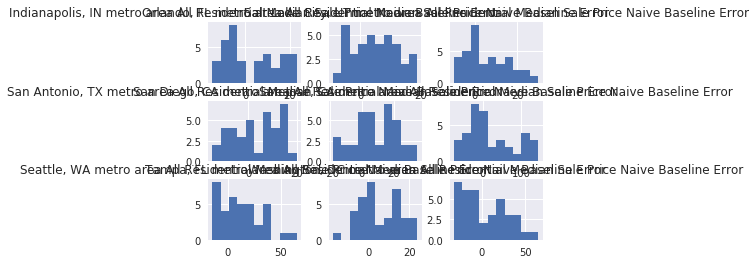

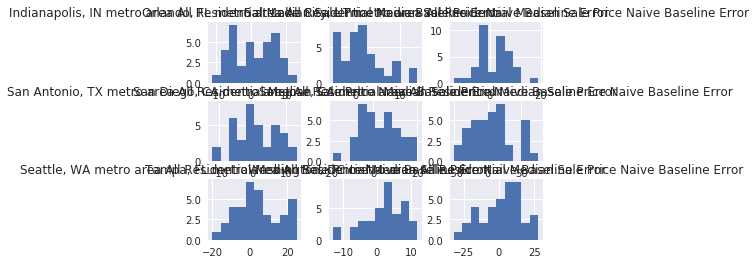

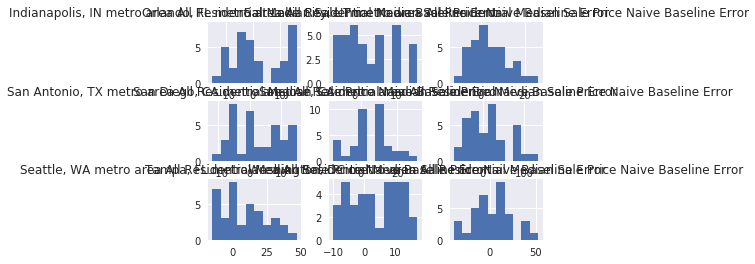

In [87]:
model_error_distribution = {}
model_error_distribution['T+1'] = []
model_error_distribution['T+2'] = []
model_error_distribution['T+3'] = []
models = []
for model in list(hold_model_error_dict_t1.keys()):
    print(model)
    models.append(model)
    for t in list(hold_model_error_dict_ts.keys()):
        #print('{}: {}'.format(t,hold_model_error_dict_ts[t][model][start_last_3_years:])
        model_error_distribution[t].append(hold_model_error_dict_ts[t][model][start_last_3_years:])

# look at model error for 1 city

In [ ]:
city_holdout_list

# each city predictions

In [182]:
hold_city_add_dict_t1 = pickle.load(open("hold_city_add_dict_t1.p", "rb"))
hold_city_add_dict_t2 = pickle.load(open("hold_city_add_dict_t2.p", "rb"))
hold_city_add_dict_t3 = pickle.load(open("hold_city_add_dict_t3.p", "rb"))

In [183]:
hold_city_add_dict_ts = {}
hold_city_add_dict_ts['T+1'] = hold_city_add_dict_t1
hold_city_add_dict_ts['T+2'] = hold_city_add_dict_t2
hold_city_add_dict_ts['T+3'] = hold_city_add_dict_t3

In [184]:
hold_city_add_dict_t1[city]

NameError: name 'city' is not defined

In [ ]:
# city_performance = {}
# city_performance['T+1'] = []
# city_performance['T+2'] = []
# city_performance['T+3'] = []
# cities = []
# for city in list(hold_city_add_dict_t1.keys()):
#     print(city)
#     cities.append(cities)
#     for t in list(hold_city_add_dict_ts.keys()):
#         #print(t+': '+str(hold_model_error_dict_ts[t][model].apply(rmse).mean()))
#         print('{}: {}'.format(t,hold_city_add_dict_ts[t][city][start_last_3_years:].apply(rmse).mean()))
#         city_performance[t].append(hold_city_add_dict_ts[t][city][start_last_3_years:].apply(rmse).mean())

In [ ]:
hold_city_add_dict_ts[t][city]

# create visualization

In [185]:
sd_trend_seas_add_ts = pd.DataFrame()
sd_trend_seas_add_ts = pd.concat([sd_trend_seas_add_ts,hold_city_add_dict_ts[t][city].iloc[:,0]],axis=1)
for t in list(hold_city_add_dict_ts.keys()):
    trend = hold_city_add_dict_ts[t][city].iloc[:,2]
    #trend.name = trend.name+' '+t
    sd_trend_seas_add_ts = pd.concat([sd_trend_seas_add_ts,trend],axis=1)
#sd_trend_seas_add_ts.to_csv('sd_d3.csv',index=True)

NameError: name 'city' is not defined

In [ ]:
#sd_trend_seas_add_ts = pd.read_csv('sd_d3.csv')
sd_trend_seas_add_ts.plot(figsize=(15,4))

In [ ]:
sd_trend_seas_add_ts.head(5)

In [ ]:
# #remove names
# prefix = city+' '
# old_cols = [col for col in sd_trend_seas_add_ts.columns]
# new_cols =[]
# rename_dict = {}
# for old_col in old_cols:
#     rename_dict[old_col] = remove_prefix(old_col,prefix)
#     df_holdout = model_test_dict[city].rename(columns=rename_dict)

In [ ]:
sd_trend_seas_add_ts = sd_trend_seas_add_ts.reset_index()

In [ ]:
sd_trend_seas_add_ts = sd_trend_seas_add_ts.rename(columns={'Period End':'date',
                                                            'San Antonio, TX metro area All Residential Median Sale Price':'Median Sale Price',
                                                            'San Antonio, TX metro area All Residential Median Sale Price Best SARMA (1, 1, 0) T+1':'T+1',
                                                            'San Antonio, TX metro area All Residential Median Sale Price Best SARMA (1, 1, 0) T+2':'T+2',
                                                            'San Antonio, TX metro area All Residential Median Sale Price Best SARMA (1, 1, 0) T+3':'T+3'})

In [ ]:
sd_trend_seas_add_ts = sd_trend_seas_add_ts.set_index('date')

In [ ]:
sd_trend_seas_add_ts = sd_trend_seas_add_ts.dropna(axis=0)

In [ ]:
#'./imdb-odsc/'
sd_trend_seas_add_ts.to_csv('./imdb-odsc/sa_arima_d3.tsv',sep='\t',index=True)

# city error

In [ ]:
hold_city_error_dict_t1 = pickle.load(open("hold_city_error_dict_t1.p", "rb"))
hold_city_error_dict_t2 = pickle.load(open("hold_city_error_dict_t2.p", "rb"))
hold_city_error_dict_t3 = pickle.load(open("hold_city_error_dict_t3.p", "rb"))

In [ ]:
hold_city_error_dict_ts = {}
hold_city_error_dict_ts['T+1'] = hold_city_error_dict_t1
hold_city_error_dict_ts['T+2'] = hold_city_error_dict_t2
hold_city_error_dict_ts['T+3'] = hold_city_error_dict_t3

In [ ]:
for i in range(len(hold_city_error_dict_ts[t][city].columns)):
    print(i)

In [ ]:
models_city_performance = {}
#for i,model in enumerate(hold_city_error_dict_ts['T+1'][city_holdout_list[0]].columns):
for i,model in enumerate(hold_model_error_dict_t1.keys()):
    city_performance = {}
    for city in city_holdout_list:
        city_performance[city] = []
        for t in list(hold_city_error_dict_ts.keys()):
            city_performance[city].append(hold_city_error_dict_ts[t][city][start_last_3_years:].iloc[:,i].apply(rmse).sum())
        cp = pd.DataFrame(city_performance)
        cp = cp.T
        cp.columns = list(hold_city_error_dict_ts.keys())
        cp = cp[sorted(cp.columns)]
    models_city_performance[model] = cp
        


            #print(hold_city_error_dict_ts[t][city][start_last_3_years:].iloc[:,2].apply(rmse).sum())

In [ ]:
models_city_performance.keys()
#models_city_performance[model]

In [ ]:
models_city_performance['Best ARIMA Add Error'].T

In [ ]:
models_city_performance['Trend Seasonality Add Error'].T

# look at trained models most important coeficients

In [ ]:
#trained_models_dict['Median Sale Price Naive Baseline Pred Error T+3']['coefs']#.head(10).plot(kind='bar')
trained_models_dict[model]['coefs']
# coefs = trained_models_dict[model]['coefs']
# coefs#.set_index('col')

In [ ]:
for model in [model for model in list(trained_models_dict.keys()) if 'Seasonality' in model]:
    trained_models_dict[model]['coefs']

In [ ]:
trend_seas_coefs_ts = pd.DataFrame()
for model in [model for model in list(trained_models_dict.keys()) if 'Seasonality' in model]:
    coefs = trained_models_dict[model]['coefs']
    coefs = coefs.rename(columns={'coef':model})
    #coefs.set_index('col',inplace=True)
    trend_seas_coefs_ts = pd.concat([trend_seas_coefs_ts,coefs],axis=1)

In [ ]:
trend_seas_coefs_ts.sort_values(ascending=False,by='Median Sale Price Trend Seasonality Pred Error T+1').head(15).plot(kind='barh')

# distribution of model error

In [ ]:
models = []
plt.figure(figsize=(15,5))
for model in list(model_error_dict.keys()):
    sns.distplot(model_error_dict[model].apply(rmse),bins=20)
    models.append(model)
plt.legend(models)
plt.title('Across City Model RMSE')

In [ ]:
c = ['Orlando, FL metro area']
for city in c:
    hold_city_add_dict[city].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.figure()
    for i in range(len(hold_city_add_dict[city].columns)-1):
        plt.scatter(hold_city_add_dict[city].iloc[:,0],hold_city_add_dict[city].iloc[:,i+1])
        plt.title(city+' Predictions')
        plt.xlabel('real')
        plt.ylabel('predicted')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.figure()
    hold_city_error_dict[city].plot(kind='box',title=city,vert=False)#,xlim=(-150,150))

In [ ]:
plt.scatter(hold_city_add_dict[city].iloc[:,0],hold_city_add_dict[city].iloc[:,5])

# ----------------
# supervised prediction problem, without layering prediction error on top of decomposition or arima

# predict supervised target holdout cities

In [473]:
from sklearn.decomposition import PCA

df = model_train_dict['Median Sale Price Supervised Target'].copy()

#df = df.apply(lambda x: pd.to_numeric(x,errors='ignore'))
for col in df.columns:
    df[col] = df[col].replace(-np.inf,np.nan)
    df[col] = df[col].replace(np.nan,df[col].min())

target_t1 = [col for col in df.columns if 'T+1' in col][0]

X = df.drop([target_t1],axis=1)
y = df[target_t1]

# pca = PCA()
# X = pca.fit_transform(X)

#holdout
# X, X_hold, y, y_hold = train_test_split(X,y,test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

#timewise
# X_train = X[start_middle_3_years:end_middle_3_years]
# y_train = y[start_middle_3_years:end_middle_3_years]
# X_test = X[end_middle_3_years:]
# y_test = y[end_middle_3_years:]

KeyError: 'Median Sale Price Supervised Target'

In [ ]:
#[col for col in X.columns if 'Median Sale Price' in col]

In [ ]:
#model
#reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=50) #.10
#reg = LinearSVR(C=5, epsilon=1) #best for unscaled data reg = LinearSVR(C=.07, epsilon=4) #.48 trend
reg = RandomForestRegressor(n_estimators=10) #.11
#reg = ElasticNet(l1_ratio=.3) # .42 for trend

#model fit test
reg.fit(X_train,y_train)
#model pred test
y_pred = reg.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index
#model pred hold
y_pred_hold = reg.predict(X_hold)
y_pred_hold = pd.Series(y_pred_hold)
y_pred_hold.index = y_hold.index

score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
print(np.sqrt(-score).mean())

#y_pred = reg.predict(X_hold)
print(r2_score(y_test,y_pred))
print(r2_score(y_hold,y_pred_hold))

plt.scatter(y_test,y_pred)
plt.xlabel('prediction')
plt.ylabel('actual')

plt.figure()
plt.scatter(y_hold,y_pred_hold)
plt.xlabel('prediction')
plt.ylabel('actual')

reg.fit(X,y)

# importance for nontimeseries split

In [ ]:
importance = pd.DataFrame(list(zip(X.columns,reg.feature_importances_)))
#importance = pd.DataFrame(list(zip(X.columns,reg.coef_)))
importance.columns = ['col','coef']
importance = importance.sort_values(by='coef',ascending=False).head(10)
importance

# importance for timewise split

In [ ]:
importance = pd.DataFrame(list(zip(X.columns,reg.feature_importances_)))
#importance = pd.DataFrame(list(zip(X.columns,reg.coef_)))
importance.columns = ['col','coef']
importance = importance.sort_values(by='coef',ascending=False).head(10)
importance

# try predicting a holdout city with the trained sueprvised model

In [ ]:
df = pd.read_csv('./clean_top50.csv')
df['Period End'] = pd.to_datetime(df['Period End'])
df = df.set_index('Period End')
df = impute_knn(df,5)

In [ ]:
city_holdout_list

In [ ]:
model_test_dict = {}
for city in city_holdout_list:
#    for model in models[0]:
    df_sup = pd.DataFrame()
    target = city+' All Residential Median Sale Price'#[col for col in city_dict[city] if model in col][0]
    print(target)
    df_orig = df.copy()
    df_orig = subset(df_orig,city)
    #df_orig = subset(df_orig,'All Residential')
    df_orig = df_orig.dropna(axis=1)
    target_df = df_orig[target]
    target_df.name = city+' Supervised Target'
    df_orig = pd.concat([df_orig,target_df],axis=1)

    df_sup = create_supervised2(df_orig,target_df.name)

    model_test_dict[city] = df_sup


In [ ]:
#model_test_dict = {}
target_t1 = 'T+1'
target_t2 = 'T+2'
target_t3 = 'T+3'
for city in city_holdout_list:
    for col in [col for col in model_test_dict[city].columns if target_t1 in col or target_t2 in col or target_t3 in col]:
        #print(col)
        model_test_dict[col] = model_test_dict[city][col]
        model_test_dict[city].drop(col,axis=1,inplace=True)

In [ ]:
#[col for col in model_test_dict[city].columns if 'Median Sale Price' in col]

In [ ]:
print(X.shape)
print(model_test_dict[city].shape)

In [ ]:
city

In [ ]:
#remove names
prefix = city+' '
old_cols = [col for col in model_test_dict[city].columns]
new_cols =[]
rename_dict = {}
for old_col in old_cols:
    rename_dict[old_col] = remove_prefix(old_col,prefix)
    df_holdout = model_test_dict[city].rename(columns=rename_dict)

In [ ]:
# for xcol in [col for col in X.columns]:
#     if xcol not in sorted([col for col in df_holdout.columns]):
#         print(xcol)

# for pair in list(zip(sorted([col for col in df_holdout.columns]),sorted([col for col in X.columns]))):
#     #if pair[0] != pair[1]:
#     print(pair)

In [ ]:
y_pred = reg.predict(model_test_dict[city])
y_pred = pd.Series(y_pred)
y_pred.index = model_test_dict[city].index
y_pred.name = 'pred'
y_pred.plot(legend='a')
model_test_dict['Orlando, FL metro area Supervised Target T+3'].plot(legend='a')

In [ ]:
model_train_dict['Median Sale Price Best SARMA (0, 1, 11) Pred Error'].shape

# set up grid search

In [ ]:
import warnings
#warnings.filterwarnings("ignore") # specify to ignore warning messages
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

p = range(0,6) 
q = range(0,1)
d = range(0,3)
pdq = list(itertools.product(p,d,q))

# run t+1

In [ ]:
#%%time
city_dict = {}

for city in city_list:
    target = city+' All Residential Median Sale Price'
    #print(target)
    df_orig = df.copy()
    df_orig = subset(df_orig,city)
    df_orig = subset(df_orig,'All Residential')
    df_orig = df_orig.dropna(axis=1)
    
    #build empty containers
    city_df = pd.DataFrame()
    resid_df = pd.DataFrame()
    
    #city_df = Target(df_orig,target,city_df,time_list)
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(15,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(15,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(15,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(16,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(16,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(16,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(17,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(17,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(17,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(18,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(18,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(18,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(19,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(19,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(19,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(20,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(20,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(20,2,0))

    #city
    city_df = city_df.dropna(how='all')
    city_dict[city] = city_df

In [ ]:
city_dict.keys()

In [ ]:
import re

# RERUN get lowest rmse for grid searched armas 
- Best ARMA (15, 2, 0)     200.643041
- Best ARMA (19, 0, 0)    190.817168
- est SARMA (0, 1, 11) 187

In [ ]:
all_city_arma = {}
for city in city_list:
    all_city_arma[city] = []
    for i in range(len(city_dict[city].columns)):
        all_city_arma[city].append((city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i]).apply(rmse).sum())

In [ ]:
train_grid_arma_df = pd.DataFrame(all_city_arma,columns=city_list).T
train_grid_arma_df.columns = [col[-19:] for col in city_dict[city].columns]
train_grid_arma_df.to_csv('train_grid_arma4.csv',index=True)

In [ ]:
train_grid_arma_df.mean()

In [ ]:
#%%time
city_dict = {}

for city in city_list:
    target = city+' All Residential Median Sale Price'
    #print(target)
    df_orig = df.copy()
    df_orig = subset(df_orig,city)
    df_orig = subset(df_orig,'All Residential')
    df_orig = df_orig.dropna(axis=1)
    
    #build empty containers
    city_df = pd.DataFrame()
    resid_df = pd.DataFrame()   
    
    city_df = SARMA(df_orig,target,city_df,time_list,param=(5,0,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(5,1,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(5,2,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(6,0,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(6,1,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(6,2,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(7,0,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(7,1,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(7,2,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(8,0,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(8,1,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(8,2,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(9,0,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(9,1,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(9,2,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(10,0,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(10,0,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(10,2,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(11,1,0),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,5),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,5),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,5),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,6),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,6),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,6),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,7),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,7),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,7),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,8),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,8),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,8),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,9),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,9),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,9),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,10),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,10),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,10),param_seasonal=(1,1,1,12))
    city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,11),param_seasonal=(1,1,1,12))

    #city
    city_df = city_df.dropna(how='all')
    city_dict[city] = city_df

In [ ]:
all_city_arma = {}
for city in city_list:
    all_city_arma[city] = []
    for i in range(len(city_dict[city].columns)):
        all_city_arma[city].append((city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i]).apply(rmse).sum())

In [ ]:
train_grid_arma_df = pd.DataFrame(all_city_arma,columns=city_list).T
train_grid_arma_df.columns = [col[-19:] for col in city_dict[city].columns]

In [ ]:
#train_grid_arma_df.to_csv('train_grid_sarma.csv',index=True)

In [ ]:
train_grid_arma_df = pd.read_csv('train_grid_sarma.csv')

In [ ]:
train_grid_arma_df.mean().sort_values()

# best arma (15,2,0) lowest median and mean

In [ ]:
#Best ARMA (0, 2, 6) 
train_grid_arma_df.mean().sort_values().head()

In [ ]:
train_grid_arma_df.median().sort_values().head()

In [ ]:
[col for col in df.columns if 'All Residential Median Sale Price' in col]